In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

Определим функцию *f*, которая задает значение поля в точке *(r, phi)* с учётом параметров *m∈ℤ* и σ∈ℜ.:

$ f(r, ϕ) = exp(-\cfrac{r^2}{σ^2}) \cdot r^{|m|} \cdot exp(i \cdot m \cdot ϕ) $

Сразу же и пропустим пучок через наклоненную линзу. В некотором приближении это преоразованияе описывает формула ниже:


$ tilt(r, ϕ) = exp(i \cdot α \cdot x \cdot y) $,

где $α$-малый угол наклона линзы

In [2]:
def f_with_tilt (r, phi, m, sigma, alpha):
    """
    Функция, описывающая входной вихревой пучок, который пропустили через наклоненную линзу. 
    :param r: удаление точки от центра изображения
    :param phi: угол точки в исходном пучке
    :param m: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол (в радианах) отклонения оси линзы от линии распространения пучка
    :return значение функции в точке (r, phi)
    """
    assert abs(alpha) <= 0.7 # т.к. предельный угол полного отражения на границе среды воздух-стекло равен 37 градусов. А вообще вроде угол должен быть прям совсем малым (по предположениям, которые позволяют юзать формулу измненеия поля при пропускании через наклюненную линзу)
    x = r*math.cos(phi)
    y = r*math.sin(phi)  
    return math.exp(-(r/sigma)**2) * r**abs(m) * (math.cos(m * phi) + math.sin(m * phi)*1j) * (math.cos(alpha * x * y) + math.sin(alpha * x * y)*1j)

In [3]:
f_with_tilt (0, 0, 3, 1, 0)

0j

Определим функцию, создающую и вычисляющую значение функции *f(r, ϕ)* в каждой точке квадратного поля размером *(-size, size)*  с числом отсчётов, переданных в кортеже *matrix_shape*

In [4]:
def get_field_with_tilt_and_control_size2(image_size, vertex_size, matrix_shape, m, sigma, alpha):
    """
    Создаёт и вычисляет значение функции f(r, ϕ) в каждой точке квадратного поля размером (-size, size) с числом отсчётов, переданных в кортеже matrix_shape
    """
    assert len(matrix_shape) == 2
    assert matrix_shape[0] % 2 == 1
    assert matrix_shape[1] % 2 == 1
    assert vertex_size <= image_size
    
    x_linspace = np.linspace(-image_size, image_size, matrix_shape[0])
    y_linspace = np.linspace(-image_size, image_size, matrix_shape[1]) 
    field = np.zeros(matrix_shape, dtype=complex)

    for i in range(matrix_shape[0]):
        for j in range(matrix_shape[1]):
            middle = min(matrix_shape) // 2
            di = i - middle
            dj = j - middle
            num_pix_vertex = middle * vertex_size / image_size
            #if abs(di) ** 2 + abs(dj) ** 2 <= middle ** 2:  # Если мы находимся внутри круга с радиусом, равным count/2
            if abs(di) ** 2 + abs(dj) ** 2 <= num_pix_vertex ** 2:  # Если мы находимся внутри круга с радиусом, равным count/2
                phi = math.atan2(di, dj) # в полярных координатах
                r_coord = math.sqrt(x_linspace[i]**2 + y_linspace[j]**2)
                field_tmp = f_with_tilt (r_coord, phi, m, sigma, alpha)
                #num_pix_vertex = middle * vertex_size / image_size
                #if abs(di) ** 2 + abs(dj) ** 2 <= num_pix_vertex ** 2:
                #    field[i,j] = 1 + np.angle(field[i,j]) * 1j
                #else:
                #    field[i,j] = 0 + np.angle(field[i,j]) * 1j
                if field_tmp != 0:
                    field_tmp /= np.abs(field_tmp)
                else:
                    field_tmp = 1 + 0j # Ставим единицу вместо нулевого значения. Такая ситуация может произойти в центре изображения.
                field[i,j] = field_tmp
    return (field, x_linspace, y_linspace)

Определим функцию, формирующую изображения пучков из комплексного numpy-массива field

In [5]:
def plot_field(field, x_linspace, y_linspace, print_mode=["amplitude", "intensity", "phase"]):
    """
    Функция отрисовывающая комплексное поле field. Масшабы по осям изображения определяются 
    :param field: Комплексное двумерное поле
    :param x_linspace: Масштаб на изображении по оси x определяется этим linspace
    :param y_linspace: Масштаб на изображении по оси x определяется этим linspace
    :param print_mode: Список, позволяет указать необходимые рисунки с помощью этого параметра из списка ["amplitude", "intensity", "phase"]
    :return значение функции в точке (r, phi)
    """
    import matplotlib.cm as cmap
    extent = [np.max(y_linspace), np.min(y_linspace), np.min(x_linspace), np.max(x_linspace)] # для корректных чисел на осях графика
    factor_for_colorbar = 15 / 12 # сраная магия подбора для matplotlib
    height_of_image = 6 # константа, пропорциональная высоте картинки
    
    if ("amplitude" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        #plt.figure(figsize=(7.5, 6)) # только для квадратных картинок
        plt.imshow(np.absolute(field), cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Амплитуда комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()

    if ("intensity" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        plt.imshow(np.absolute(field)**2, cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Интенсивность комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()
    if ("phase" in print_mode):
        plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
        plt.imshow(np.angle(field), cmap=cmap.hot, aspect='auto', extent=extent)
        plt.title("Фаза комплексного поля")
        plt.ylabel('y, расстояние (см)')
        plt.xlabel('x, расстояние (см)')
        plt.grid(True)
        plt.colorbar()
        #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
        plt.show()

Вызовем вышеописанные функции для отображения пучка *m = 3* и числом отчётов, равным *101* по горизонтали и вертикали 

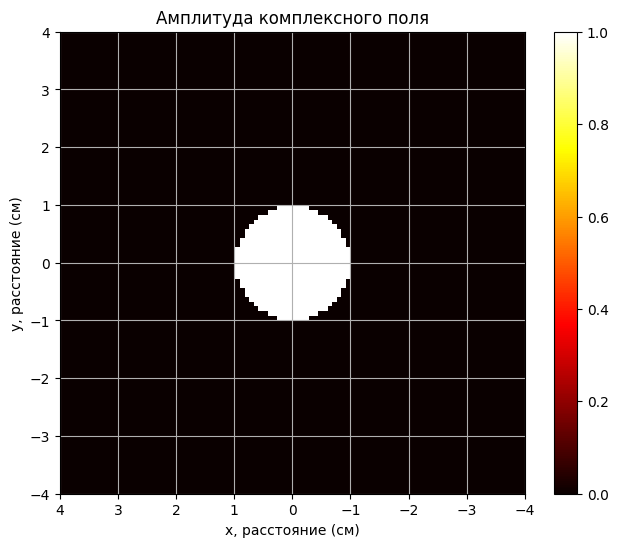

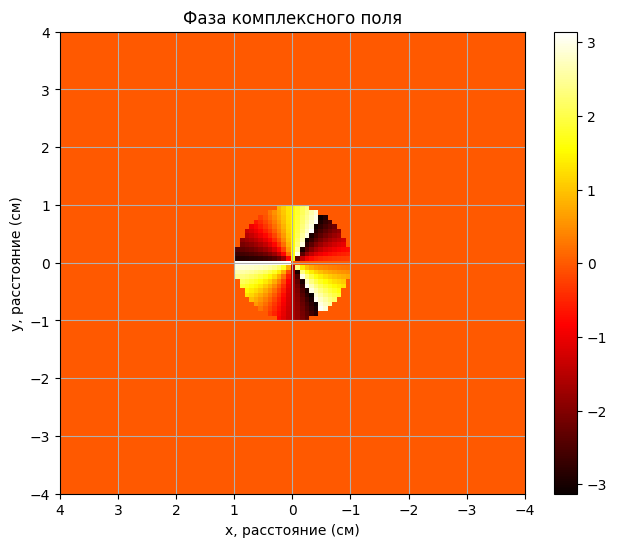

In [6]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size2(image_size=4, vertex_size=1, matrix_shape=(101, 101), m=3, sigma=1, alpha=0)
plot_field(field, x_linspace, y_linspace, print_mode=["amplitude", "phase"])

Нарисуем набор картинок модулей и фазы полученных комплексных полей

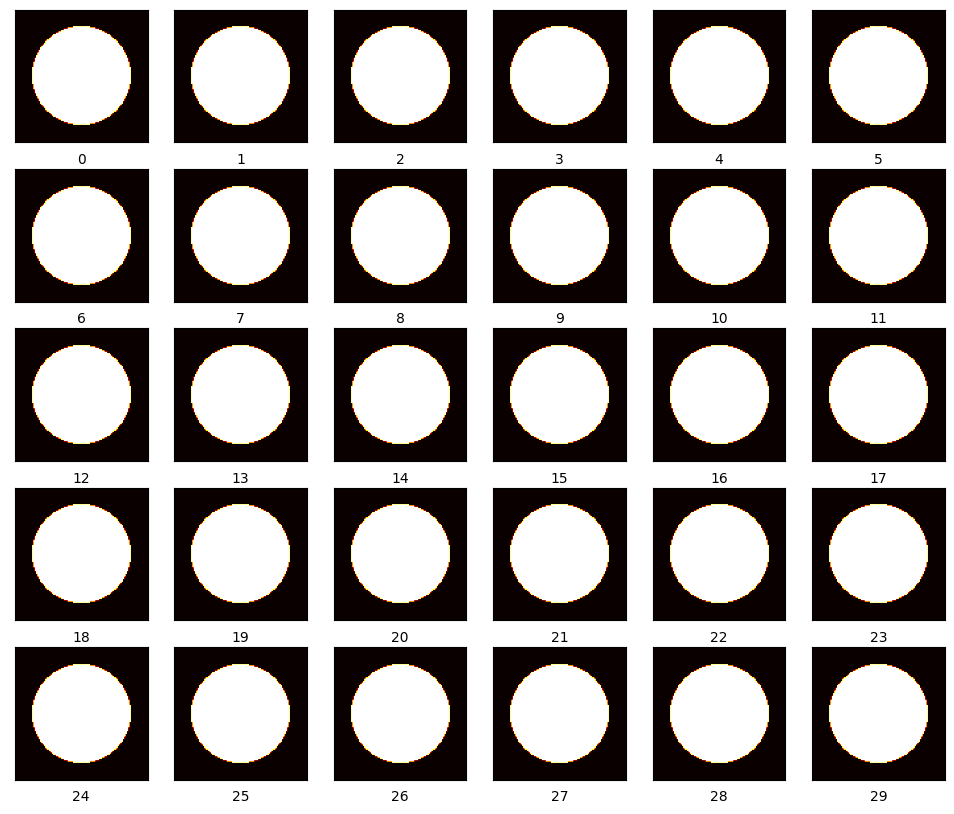

In [7]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    field, x_linspace, y_linspace = get_field_with_tilt_and_control_size2(image_size=4, vertex_size=3, matrix_shape=(101, 101), m=i, sigma=1, alpha=0)
    plt.imshow(np.absolute(field), cmap=plt.cm.hot)
#     plt.xlabel(class_names[beam_label[i]])
    plt.xlabel(i)


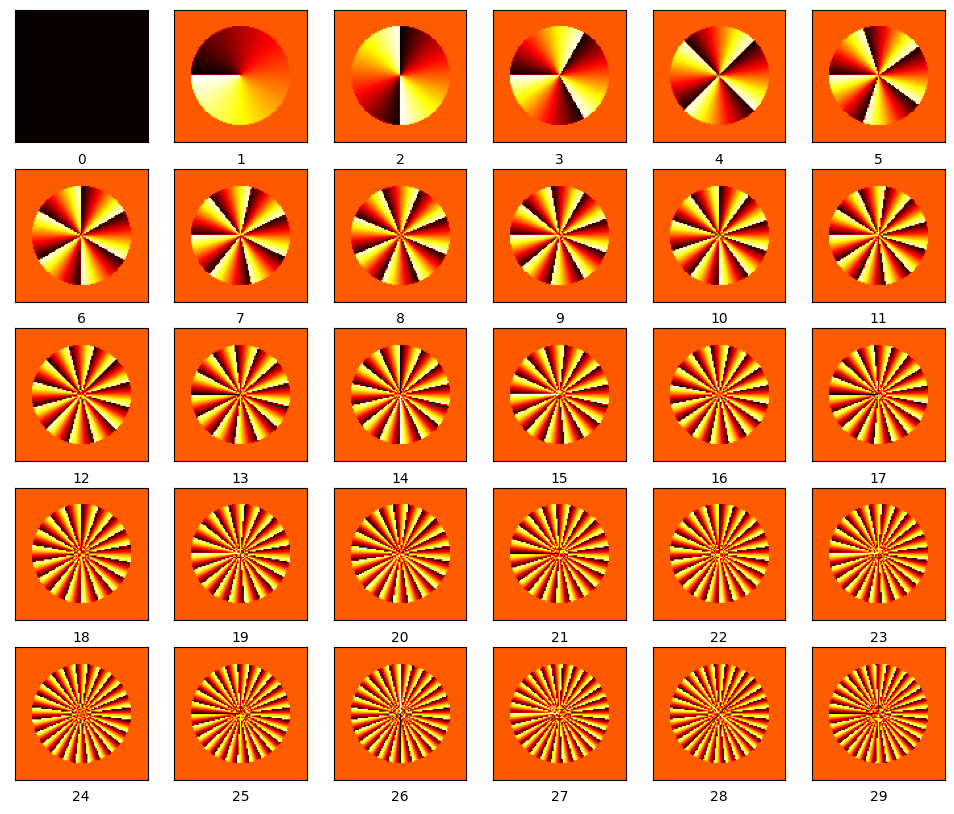

In [8]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    field, x_linspace, y_linspace = get_field_with_tilt_and_control_size2(image_size=4, vertex_size=3, matrix_shape=(101, 101), m=i, sigma=1, alpha=0)
    plt.imshow(np.angle(field), cmap=plt.cm.hot)
#     plt.xlabel(class_names[beam_label[i]])
    plt.xlabel(i)


### Определим функцию, которая дополняет нулями исходную картинку:

In [9]:
def get_field_padded_zeros(field, new_shape, x_linspace, y_linspace):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param field: изображение
    :param new_shape: новые размеры изображения
    :param x_linspace: размеры входного изображения (в см/м/мм)
    :param y_linspace: размеры входного изображения (в см/м/мм)
    """
    assert len(field.shape) == 2
    assert field.shape[0] % 2 == 1
    assert field.shape[1] % 2 == 1
    
    assert len(new_shape) == 2
    assert new_shape[0] % 2 == 1
    assert new_shape[1] % 2 == 1
    
    field_padded_zeros = np.zeros(new_shape, dtype=field.dtype)
    #print(field_padded_zeros)
    
    diff0dimetional=(new_shape[0]-field.shape[0])//2
    #print("diff0dimetional =",diff0dimetional)
    diff1dimetional=(new_shape[1]-field.shape[1])//2
    #print("diff1dimetional =",diff1dimetional)
    
    if (diff0dimetional >= 0 and diff1dimetional >= 0):  
        #print("slicesindex=[",diff0dimetional, ":", new_shape[0]-diff0dimetional, ",", diff1dimetional, ":", new_shape[1]-diff1dimetional,"]")
        field_padded_zeros[diff0dimetional : new_shape[0]-diff0dimetional, diff1dimetional : new_shape[1]-diff1dimetional] = field
    else:
        if (diff0dimetional <= 0 and diff1dimetional <= 0):
            #print("slicesindex=[",-diff0dimetional, ":", field.shape[0]+diff0dimetional, ",", -diff1dimetional, ":", field.shape[1]+diff1dimetional,"]")
            field_padded_zeros = field[-diff0dimetional : field.shape[0]+diff0dimetional, -diff1dimetional : field.shape[1]+diff1dimetional]
        else:
            raise ValueError("Код не предусматривает, что необходимо дополнять нулями по одной оси и обрезать по другой. Реализация подразумевает, что можно либо дополнять нулями либо обрезать")
    #пересчитываем linspace:
    x_linspace_padded_zeros = x_linspace / field.shape[0] * new_shape[0]
    y_linspace_padded_zeros = y_linspace / field.shape[1] * new_shape[1]
    return (field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)
    
# For tests
# get_field_padded_zeros(np.array([[4]]), (7,7), np.array([-1,1]), np.array([-2,2]))
# get_field_padded_zeros(np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]), (7,5), np.array([-1,1]), np.array([-2,2]))

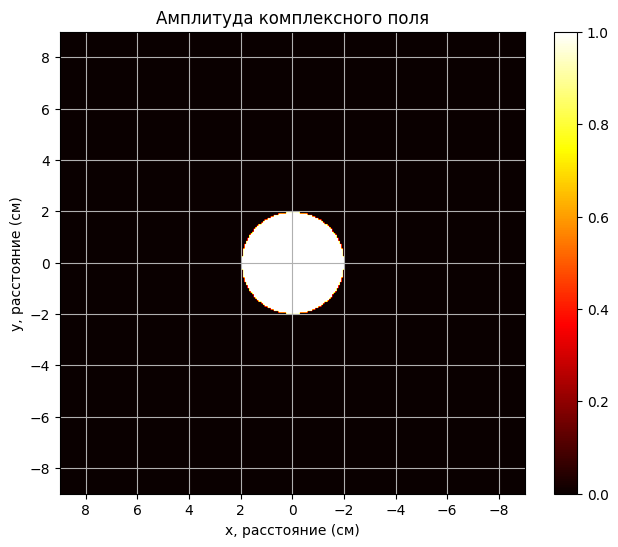

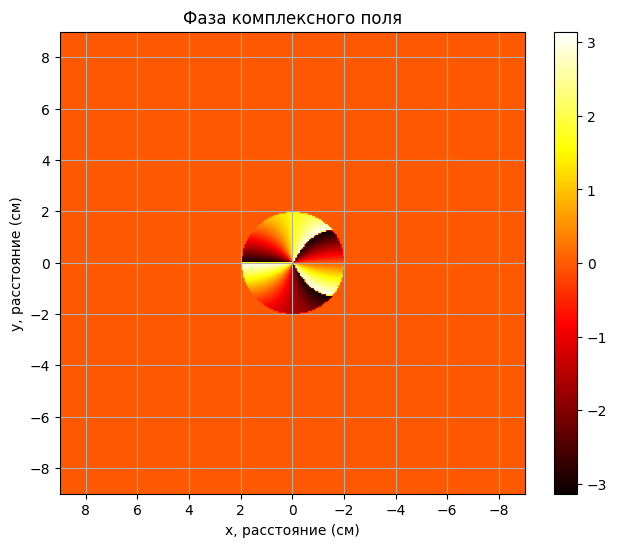

In [10]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size2(image_size=3, vertex_size=2, matrix_shape=(101, 101), m=3, sigma=1, alpha=0.5)
field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (303, 303), x_linspace, y_linspace)
plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros, print_mode=["amplitude", "phase"])

## Определим функцию, которая выдает суперпозицию поля с разными параметрами m и соответствующими весами c. Она также выдаёт пропущенное через FFT поле.

Размер выходного поля b = 1.6833333333333333


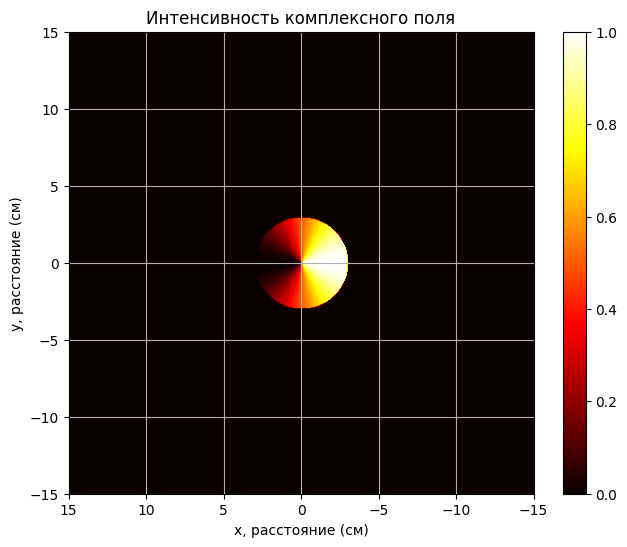

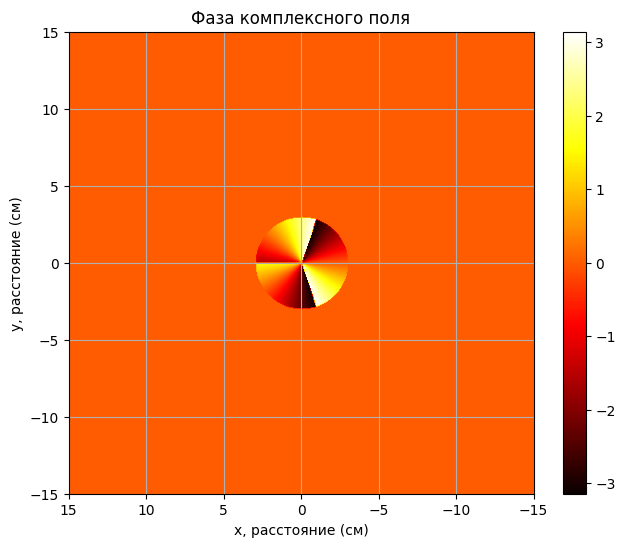

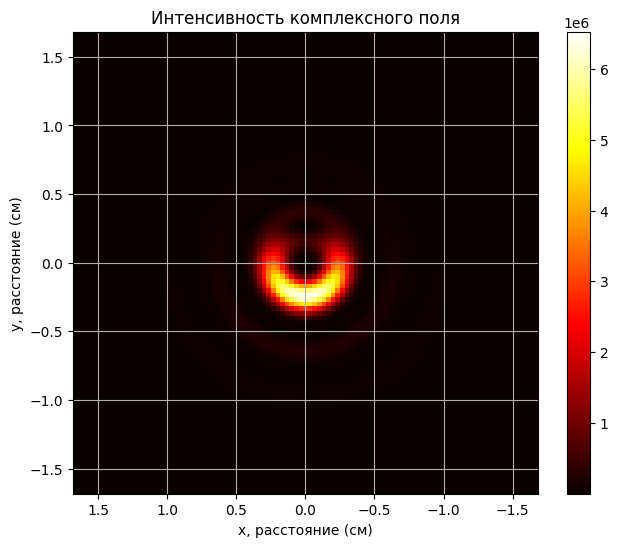

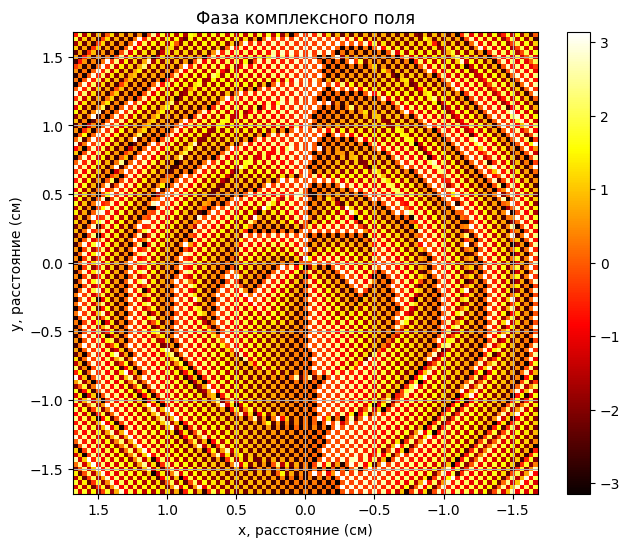

In [11]:
def get_superposition_field2_after_tilt_and_fft(a, N, M, m, c, sigma, alpha):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param a: Размер исходного поля
    :param N: Число отсчётов картинки, поле которой мы генерируем
    :param M: Число отсчётов, до которого дополняем поле до fft2
    :param m: параметр пучка - угловой орбительный момент
    :param c: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол (в радианах) отклонения оси линзы от линии распространения пучка
    :return ((field, x_linspace, y_linspace),(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2))
    """
    b=N*N/4/a/M # 
    print("Размер выходного поля b =",b)

    assert len(m)==len(c) 
    assert sum(c)>=1-1e-8 and sum(c)<=1+1e-8 # Сумма весов должна быть равна 1
    field_superposition = np.zeros((N,N), dtype=field.dtype) # Суперпозиция полей с разных m
    for m_i, c_i in zip(m, c):
        # Генерируем поле лазера
        field_i, x_linspace, y_linspace = get_field_with_tilt_and_control_size2(image_size=a, vertex_size=a, matrix_shape=(N, N), m=m_i, sigma=sigma, alpha=alpha)
        field_superposition+=c_i*field_i
    field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field_superposition, (M, M), x_linspace, y_linspace)
    # Отприсовываем получившееся поле 
    # plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

    # Выполняем fft2 преобразование (+ расщитываем масштаб)
    field_after_fft = np.fft.fft2(field_padded_zeros)
    field_after_fft = np.fft.fftshift(field_after_fft)
    # Отрезаем поле размером NxN
    field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
    # Перерасчитываем масштаб поля после fft 
    x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
    y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
    # Отрисовываем картинки после fft2
    # plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)
    
    return ((field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros),(field_after_fft, x_linspace_after_fft, y_linspace_after_fft))


(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=101, M=505, m=[2,3], c=[0.5, 0.5], sigma=1, alpha=0.0)
plot_field(field, x_linspace, y_linspace, print_mode=["intensity", "phase"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

Сгенерируем пучок, аналогичный нижеприведенному, который был сфотографирован Порфирьевым Алексеем Петровичем:
![real_beam](https://sun9-north.userapi.com/sun9-78/s/v1/ig2/ouTOl1sImb36P8y-MquEmr7P1cDZSKsb3vqBMXfPUHcaYZk8tXVDWbhKwLoBVSVXhDHlJyJMMq7HaPpWToLIK65P.jpg?size=1280x960&quality=96&type=album)


Размер выходного поля b = 4.026677667766776


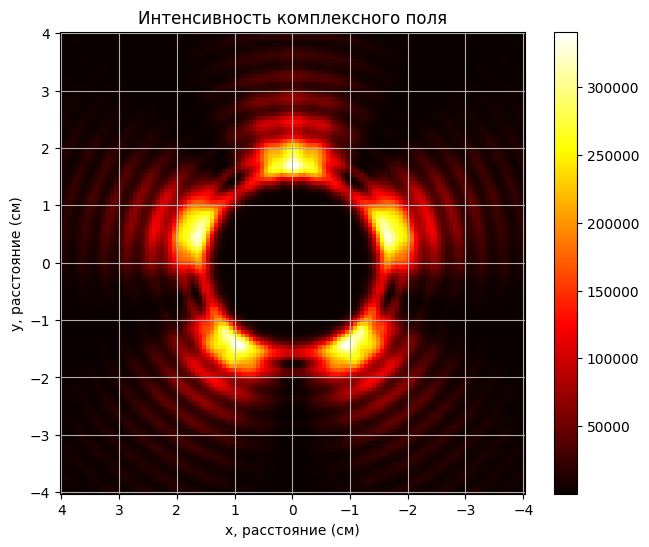

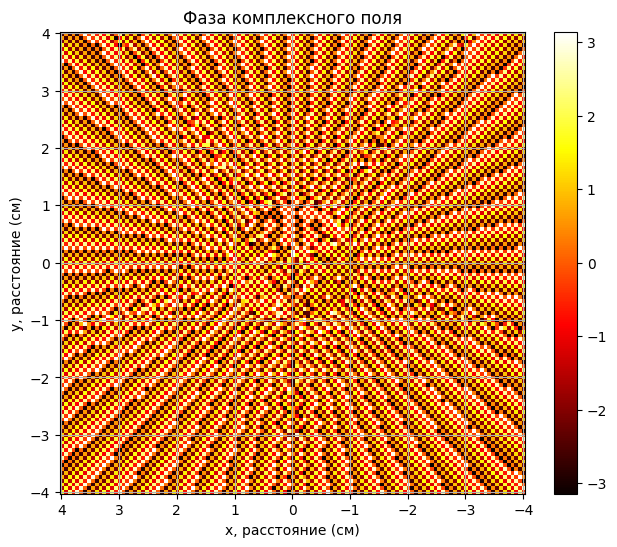

In [14]:
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=121, M=303, m=[-30,-25], c=[0.5, 0.5], sigma=1, alpha=0.0)
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

Размер выходного поля b = 1.6833333333333333


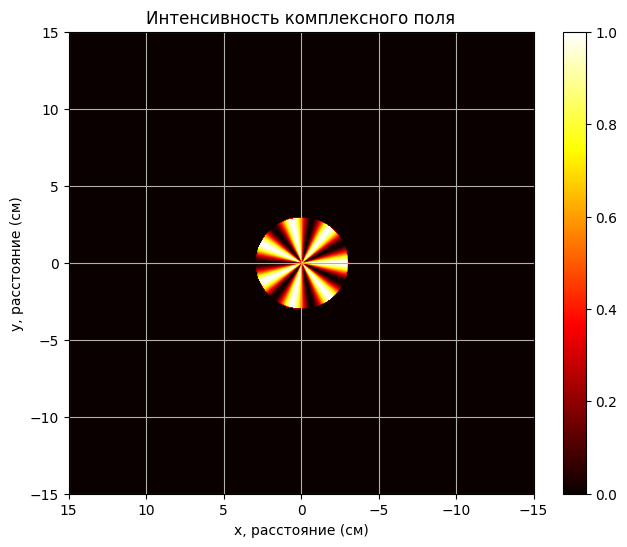

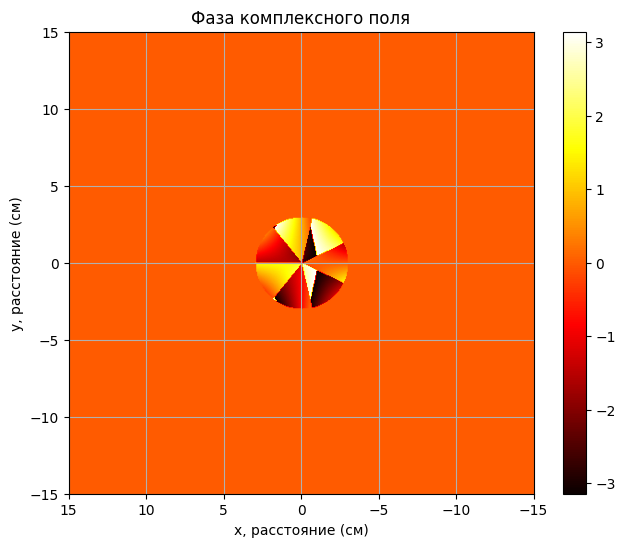

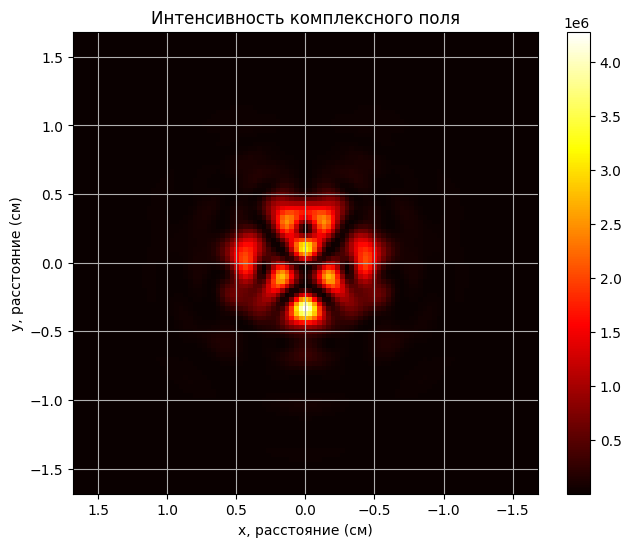

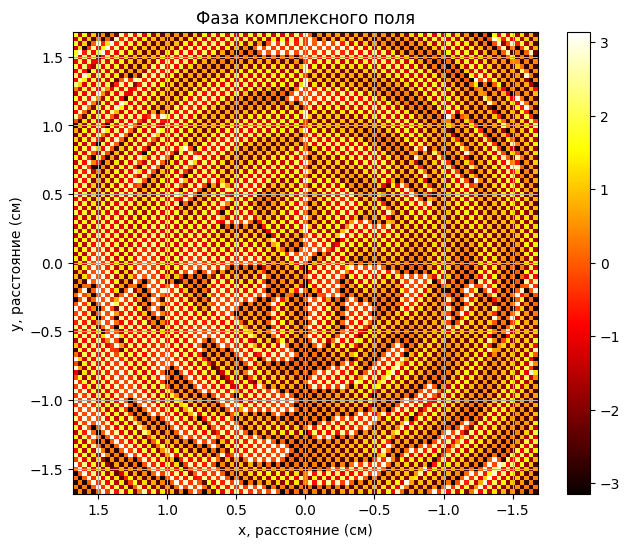

In [13]:

(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=101, M=505, m=[-4,3], c=[0.5, 0.5], sigma=1, alpha=0.5)
plot_field(field, x_linspace, y_linspace, print_mode=["intensity", "phase"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity", "phase"])

# Начнём собирать датасет

#### Берем суперпозиции вихрей с постоянными и равными весам. Величины углового орбитального момента m целые, различные по знакам и лежат в диапазоне [-5, 5]

Размер выходного поля b = 1.6833333333333333


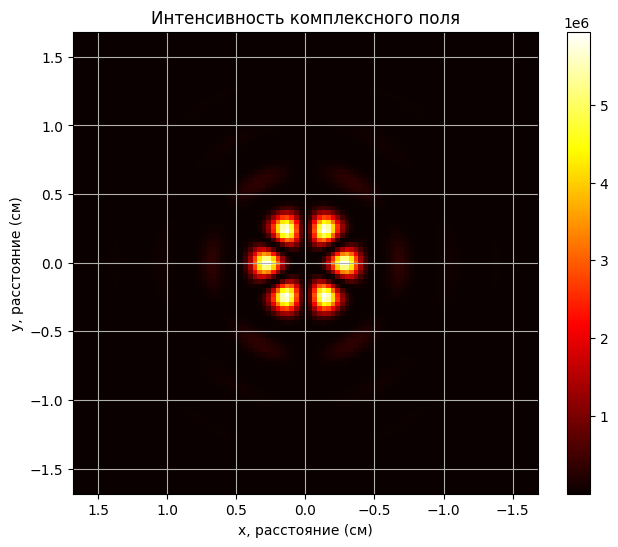

In [16]:
this_m = [-3, 3]
this_c = [0.5, 0.5]
this_alpha=0.0
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=101, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
# plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

Размер выходного поля b = 1.0826732673267327


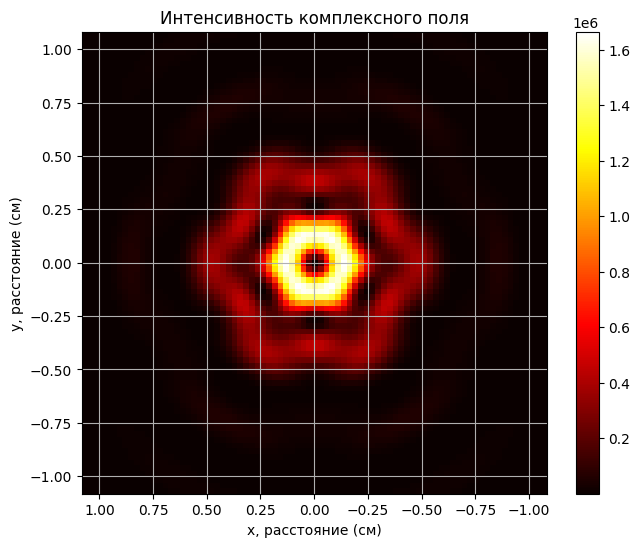

In [18]:
this_m = [-5, 1]
this_c = [0.5, 0.5]
this_alpha=0.0
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=81, M=505, m=this_m, c=this_c, sigma=1, alpha=this_alpha)
#plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

#### **Сгенерируем выборку в несколько классов и формируем массив изображений и их метки**

In [19]:
image_shape=81
beam_images=[]
beam_label=[]

counter_pictures=0
for i in range(0,6): #0..5
    for j in range(-5,0): #-5..-1
        for c1 in [0.4, 0.5, 0.6]:
            counter_pictures+=1
            print("|m1-m2| =", i-j, "\tm1 =", i, "m2 =", j, "\tc1=", c1, "c2=", 1-c1)
            this_m = [i, j]
            (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=3, N=image_shape, M=505, m=this_m, c=[c1, 1-c1], sigma=1, alpha=0.0)
            #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
            field_after_fft2 = abs(field_after_fft2)
            beam_images.append(field_after_fft2[np.newaxis, ...])
            beam_label.append([i-j,i,j,c1,1-c1])
            
            #!plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])
        
        
beam_images=np.concatenate(beam_images, axis=0)
beam_images.shape

|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 5 	m1 = 0 m2 = -5 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 4 	m1 = 0 m2 = -4 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 3 	m1 = 0 m2 = -3 	c1= 0.6 c2= 0.4
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 2 	m1 = 0 m2 = -2 	c1= 0.4 c2= 0.6
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 2 	m1 = 0 m2 = -2 	c1= 0.5 c2= 0.5
Размер выходного поля b = 1.0826732673267327
|m1-m2| = 

(90, 81, 81)

[2, 1, -1, 0.6, 0.4]


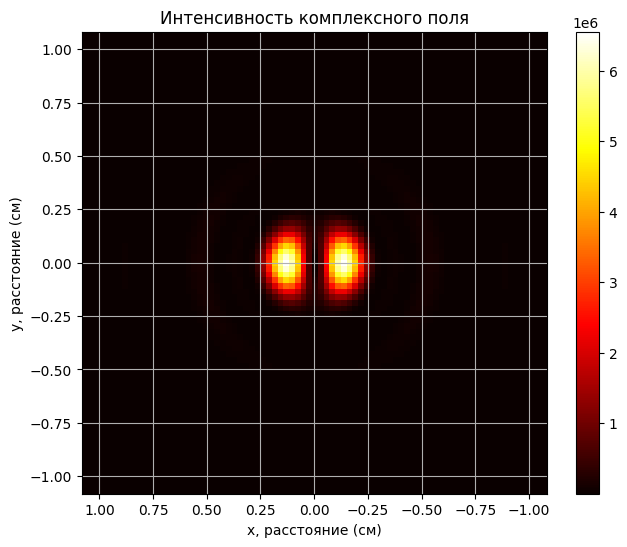

In [20]:
print(beam_label[29])
plot_field(beam_images[29], x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

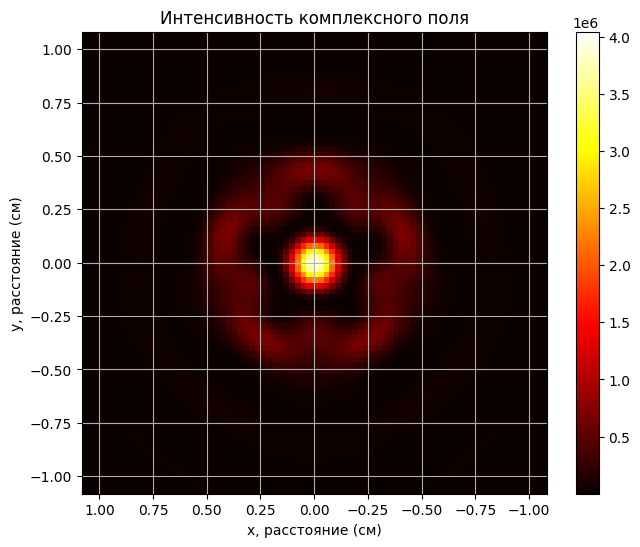

In [21]:
plot_field(beam_images[0], x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])

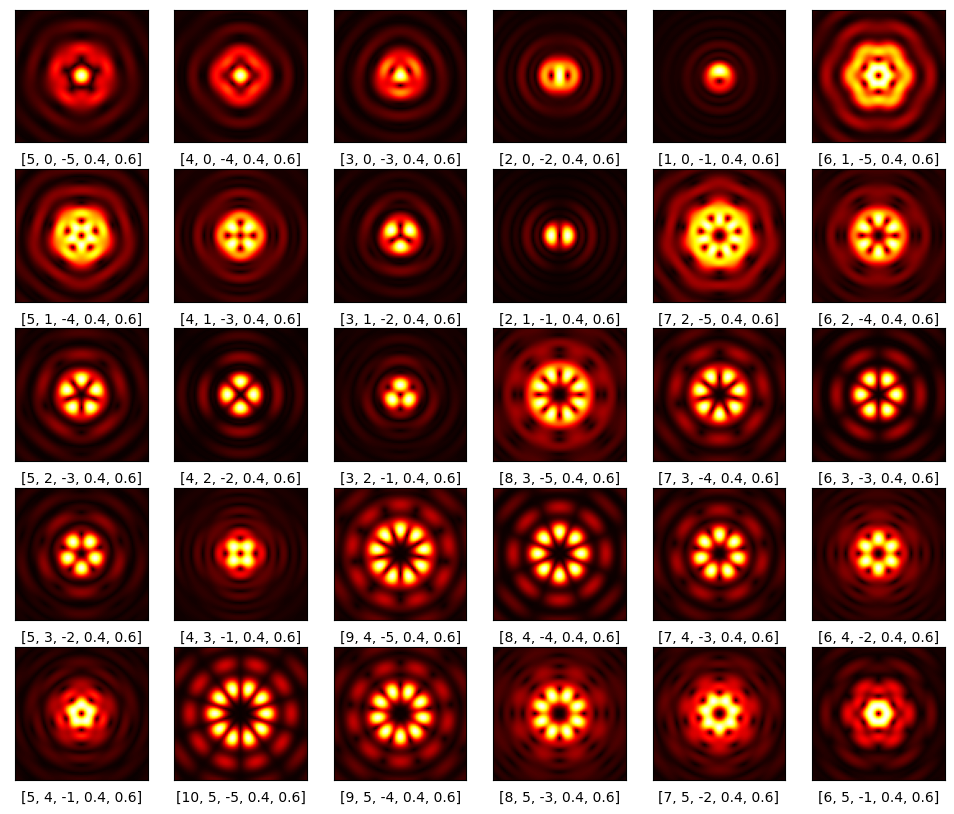

In [22]:
plt.figure(figsize=(12,10))
for i in range(30):
    plt.subplot(5,6,i+1) # индексы тут и в figure наоборот, как ни странно
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(beam_images[3*i], cmap=plt.cm.hot)
#     plt.xlabel(class_names[beam_label[i]])
    plt.xlabel(beam_label[3*i])


Забавно, что после кодирования Лезема, полученные изображения получили исажения в виде колец.

### Выясним сбалансированность данных 

In [23]:
tmp_beam_label = []
for i,_,_,_,_ in beam_label:
    tmp_beam_label.append(i)
tmp_beam_label


for i in set(tmp_beam_label):
    print(i,"\t", tmp_beam_label.count(i))


1 	 3
2 	 6
3 	 9
4 	 12
5 	 15
6 	 15
7 	 12
8 	 9
9 	 6
10 	 3


# Получим список пар угловых орбитальных моментов  реальных пучков, которые учавствовали в обучении и запишем в переменную `labels_beam_ge_60`

#### Распарсим метки изображений из файла `map.txt` в ассоциативный массив `label_dict`

In [28]:
import cv2
import os, sys

In [25]:
map_name_file = 'map.txt'
label_dict = {}   

dir_name = 'Double-OV-intenisities'
folders = os.listdir(dir_name)


for i, folder in enumerate(folders):
    print(f'Открываем папку {folder}')
    file1 = open(f'{dir_name}/{folder}/{map_name_file}', 'r')

    while True:

        # Получаем строчка за строчкой
        line = file1.readline()

        # Если строка пуста или конец файла
        if not line:
            break
        line_splitted = line.split(' ')
        num_image = int(line_splitted[0][:-1])
        a = int(line_splitted[1][:-1])
        if line_splitted[2][-1]=='\n': # в последней строке нет символа \n, обрабатываем этот случай
            b = int(line_splitted[2][:-1])
        else:
            b = int(line_splitted[2])
        if label_dict.get(num_image)!=None:
            print("Ошибка! Словарь уже имеет значение такое в себе")
        label_dict[num_image] = (a, b)
        #print(f'num_image={num_image} a={a} b={b}')

    file1.close()

Открываем папку 1-914
Открываем папку 1833-2745
Открываем папку 2747-3660
Открываем папку 918-1830


In [26]:
label_dict

{1: (-30, -29),
 2: (-30, -28),
 3: (-30, -27),
 4: (-30, -26),
 5: (-30, -25),
 6: (-30, -24),
 7: (-30, -23),
 8: (-30, -22),
 9: (-30, -21),
 10: (-30, -20),
 11: (-30, -19),
 12: (-30, -18),
 13: (-30, -17),
 14: (-30, -16),
 15: (-30, -15),
 16: (-30, -14),
 17: (-30, -13),
 18: (-30, -12),
 19: (-30, -11),
 20: (-30, -10),
 21: (-30, -9),
 22: (-30, -8),
 23: (-30, -7),
 24: (-30, -6),
 25: (-30, -5),
 26: (-30, -4),
 27: (-30, -3),
 28: (-30, -2),
 29: (-30, -1),
 30: (-30, 0),
 31: (-30, 1),
 32: (-30, 2),
 33: (-30, 3),
 34: (-30, 4),
 35: (-30, 5),
 36: (-30, 6),
 37: (-30, 7),
 38: (-30, 8),
 39: (-30, 9),
 40: (-30, 10),
 41: (-30, 11),
 42: (-30, 12),
 43: (-30, 13),
 44: (-30, 14),
 45: (-30, 15),
 46: (-30, 16),
 47: (-30, 17),
 48: (-30, 18),
 49: (-30, 19),
 50: (-30, 20),
 51: (-30, 21),
 52: (-30, 22),
 53: (-30, 23),
 54: (-30, 24),
 55: (-30, 25),
 56: (-30, 26),
 57: (-30, 27),
 58: (-30, 28),
 59: (-30, 29),
 60: (-30, 30),
 61: (-29, -30),
 62: (-29, -28),
 63: 

Запишем в `labels_beam2` значения мод двух пучков из изображений

In [51]:
dir_name = 'Double-OV-intenisities'
folders = os.listdir(dir_name)
    

labels_beam = []
for i, folder in enumerate(folders):
    print(f'Открываем папку {folder}')
    pictures = os.listdir(f'{dir_name}/{folder}')
    pictures.remove(map_name_file)
    for k in range(len(pictures)):
        num_pictures = int(pictures[k][:-4]) # Получение номер картинки из названия. Отрезаем '.jpg' в конце строки
        if num_pictures != 0 : # Нет информации о том, что в этой картике закодировано
            labels_beam.append(label_dict[num_pictures])
    #break

Открываем папку 1-914
Открываем папку 1833-2745
Открываем папку 2747-3660
Открываем папку 918-1830


Определим количество изображений каждого класса

In [52]:
labels_list = [abs(one_label[0]-one_label[1]) for one_label in labels_beam]
labels = np.array(labels_list)

In [53]:
for i in set(labels_list):
    print(i,"\t", labels_list.count(i))


1 	 116
2 	 115
3 	 116
4 	 114
5 	 112
6 	 110
7 	 108
8 	 106
9 	 104
10 	 102
11 	 100
12 	 98
13 	 96
14 	 94
15 	 92
16 	 90
17 	 88
18 	 86
19 	 84
20 	 82
21 	 80
22 	 78
23 	 76
24 	 74
25 	 72
26 	 70
27 	 68
28 	 66
29 	 64
30 	 62
31 	 60
32 	 58
33 	 56
34 	 54
35 	 52
36 	 50
37 	 48
38 	 46
39 	 44
40 	 42
41 	 40
42 	 38
43 	 36
44 	 34
45 	 32
46 	 30
47 	 28
48 	 26
49 	 24
50 	 22
51 	 20
52 	 18
53 	 16
54 	 14
55 	 12
56 	 10
57 	 8
58 	 6
59 	 4
60 	 2


### Уберем из датасета классы, у которых меньше 60 различных изображений.

In [49]:
# Положим в список need_labels классы, у которых меньше trashhold_num_classes изображений
trashhold_num_classes = 60
need_labels = []
for i in set(labels_list):
    count = labels_list.count(i)
    if count > trashhold_num_classes:
        print(i,"\t", labels_list.count(i))
        need_labels.append(i)

1 	 116
2 	 115
3 	 116
4 	 114
5 	 112
6 	 110
7 	 108
8 	 106
9 	 104
10 	 102
11 	 100
12 	 98
13 	 96
14 	 94
15 	 92
16 	 90
17 	 88
18 	 86
19 	 84
20 	 82
21 	 80
22 	 78
23 	 76
24 	 74
25 	 72
26 	 70
27 	 68
28 	 66
29 	 64
30 	 62


In [56]:
mask_ge_60 = []
for label in labels:
    mask_ge_60.append(label in need_labels)

labels_beam_ge_60 = np.array(labels_beam)[mask_ge_60]

In [57]:
labels_beam_ge_60.shape

(2723, 2)

# Сформируем датасет смоделированных пучков на основе пар мод `labels_beam_ge_60`

In [59]:
labels_beam_ge_60

array([[-30, -29],
       [-30, -20],
       [-30, -19],
       ...,
       [-14,   7],
       [-14,   8],
       [-14,   9]])

In [107]:
counter_pictures = 0
beam_images_ge_60 = []
beam_labels_ge_60 = []
for i,j in labels_beam_ge_60:
    counter_pictures+=1
    print(f"{counter_pictures}.\t|m1-m2| = {i-j}\tm1 = {i} m2 = {j}")
    this_m = [i, j]
    (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=5, N=81, M=101, m=this_m, c=[0.5, 0.5], sigma=1, alpha=0.0)
    #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
    field_after_fft2 = abs(field_after_fft2)
    beam_images_ge_60.append(field_after_fft2[np.newaxis, ...])
    beam_labels_ge_60.append([i-j,i,j])
beam_images_ge_60=np.concatenate(beam_images_ge_60, axis=0)
beam_images_ge_60.shape

1.	|m1-m2| = -1	m1 = -30 m2 = -29
Размер выходного поля b = 3.248019801980198
2.	|m1-m2| = -10	m1 = -30 m2 = -20
Размер выходного поля b = 3.248019801980198
3.	|m1-m2| = -11	m1 = -30 m2 = -19
Размер выходного поля b = 3.248019801980198
4.	|m1-m2| = -12	m1 = -30 m2 = -18
Размер выходного поля b = 3.248019801980198
5.	|m1-m2| = 2	m1 = -28 m2 = -30
Размер выходного поля b = 3.248019801980198
6.	|m1-m2| = 1	m1 = -28 m2 = -29
Размер выходного поля b = 3.248019801980198
7.	|m1-m2| = -1	m1 = -28 m2 = -27
Размер выходного поля b = 3.248019801980198
8.	|m1-m2| = -2	m1 = -28 m2 = -26
Размер выходного поля b = 3.248019801980198
9.	|m1-m2| = -3	m1 = -28 m2 = -25
Размер выходного поля b = 3.248019801980198
10.	|m1-m2| = -4	m1 = -28 m2 = -24
Размер выходного поля b = 3.248019801980198
11.	|m1-m2| = -5	m1 = -28 m2 = -23
Размер выходного поля b = 3.248019801980198
12.	|m1-m2| = -6	m1 = -28 m2 = -22
Размер выходного поля b = 3.248019801980198
13.	|m1-m2| = -7	m1 = -28 m2 = -21
Размер выходного поля b =

105.	|m1-m2| = -17	m1 = -26 m2 = -9
Размер выходного поля b = 3.248019801980198
106.	|m1-m2| = -18	m1 = -26 m2 = -8
Размер выходного поля b = 3.248019801980198
107.	|m1-m2| = -19	m1 = -26 m2 = -7
Размер выходного поля b = 3.248019801980198
108.	|m1-m2| = -20	m1 = -26 m2 = -6
Размер выходного поля b = 3.248019801980198
109.	|m1-m2| = -21	m1 = -26 m2 = -5
Размер выходного поля b = 3.248019801980198
110.	|m1-m2| = -22	m1 = -26 m2 = -4
Размер выходного поля b = 3.248019801980198
111.	|m1-m2| = -23	m1 = -26 m2 = -3
Размер выходного поля b = 3.248019801980198
112.	|m1-m2| = -24	m1 = -26 m2 = -2
Размер выходного поля b = 3.248019801980198
113.	|m1-m2| = -25	m1 = -26 m2 = -1
Размер выходного поля b = 3.248019801980198
114.	|m1-m2| = -27	m1 = -30 m2 = -3
Размер выходного поля b = 3.248019801980198
115.	|m1-m2| = -26	m1 = -26 m2 = 0
Размер выходного поля b = 3.248019801980198
116.	|m1-m2| = -27	m1 = -26 m2 = 1
Размер выходного поля b = 3.248019801980198
117.	|m1-m2| = -28	m1 = -26 m2 = 2
Размер 

208.	|m1-m2| = -6	m1 = -23 m2 = -17
Размер выходного поля b = 3.248019801980198
209.	|m1-m2| = -7	m1 = -23 m2 = -16
Размер выходного поля b = 3.248019801980198
210.	|m1-m2| = -8	m1 = -23 m2 = -15
Размер выходного поля b = 3.248019801980198
211.	|m1-m2| = -9	m1 = -23 m2 = -14
Размер выходного поля b = 3.248019801980198
212.	|m1-m2| = -10	m1 = -23 m2 = -13
Размер выходного поля b = 3.248019801980198
213.	|m1-m2| = -11	m1 = -23 m2 = -12
Размер выходного поля b = 3.248019801980198
214.	|m1-m2| = -12	m1 = -23 m2 = -11
Размер выходного поля b = 3.248019801980198
215.	|m1-m2| = -13	m1 = -23 m2 = -10
Размер выходного поля b = 3.248019801980198
216.	|m1-m2| = -14	m1 = -23 m2 = -9
Размер выходного поля b = 3.248019801980198
217.	|m1-m2| = -15	m1 = -23 m2 = -8
Размер выходного поля b = 3.248019801980198
218.	|m1-m2| = -16	m1 = -23 m2 = -7
Размер выходного поля b = 3.248019801980198
219.	|m1-m2| = -17	m1 = -23 m2 = -6
Размер выходного поля b = 3.248019801980198
220.	|m1-m2| = -18	m1 = -23 m2 = -5


311.	|m1-m2| = -6	m1 = -30 m2 = -24
Размер выходного поля b = 3.248019801980198
312.	|m1-m2| = 10	m1 = -20 m2 = -30
Размер выходного поля b = 3.248019801980198
313.	|m1-m2| = 9	m1 = -20 m2 = -29
Размер выходного поля b = 3.248019801980198
314.	|m1-m2| = 8	m1 = -20 m2 = -28
Размер выходного поля b = 3.248019801980198
315.	|m1-m2| = 7	m1 = -20 m2 = -27
Размер выходного поля b = 3.248019801980198
316.	|m1-m2| = 6	m1 = -20 m2 = -26
Размер выходного поля b = 3.248019801980198
317.	|m1-m2| = 5	m1 = -20 m2 = -25
Размер выходного поля b = 3.248019801980198
318.	|m1-m2| = 4	m1 = -20 m2 = -24
Размер выходного поля b = 3.248019801980198
319.	|m1-m2| = 3	m1 = -20 m2 = -23
Размер выходного поля b = 3.248019801980198
320.	|m1-m2| = 2	m1 = -20 m2 = -22
Размер выходного поля b = 3.248019801980198
321.	|m1-m2| = 1	m1 = -29 m2 = -30
Размер выходного поля b = 3.248019801980198
322.	|m1-m2| = 1	m1 = -20 m2 = -21
Размер выходного поля b = 3.248019801980198
323.	|m1-m2| = -1	m1 = -20 m2 = -19
Размер выходно

414.	|m1-m2| = 4	m1 = -18 m2 = -22
Размер выходного поля b = 3.248019801980198
415.	|m1-m2| = -12	m1 = -29 m2 = -17
Размер выходного поля b = 3.248019801980198
416.	|m1-m2| = 3	m1 = -18 m2 = -21
Размер выходного поля b = 3.248019801980198
417.	|m1-m2| = 2	m1 = -18 m2 = -20
Размер выходного поля b = 3.248019801980198
418.	|m1-m2| = 1	m1 = -18 m2 = -19
Размер выходного поля b = 3.248019801980198
419.	|m1-m2| = -1	m1 = -18 m2 = -17
Размер выходного поля b = 3.248019801980198
420.	|m1-m2| = -2	m1 = -18 m2 = -16
Размер выходного поля b = 3.248019801980198
421.	|m1-m2| = -3	m1 = -18 m2 = -15
Размер выходного поля b = 3.248019801980198
422.	|m1-m2| = -4	m1 = -18 m2 = -14
Размер выходного поля b = 3.248019801980198
423.	|m1-m2| = -5	m1 = -18 m2 = -13
Размер выходного поля b = 3.248019801980198
424.	|m1-m2| = -6	m1 = -18 m2 = -12
Размер выходного поля b = 3.248019801980198
425.	|m1-m2| = -7	m1 = -18 m2 = -11
Размер выходного поля b = 3.248019801980198
426.	|m1-m2| = -13	m1 = -29 m2 = -16
Размер

517.	|m1-m2| = 2	m1 = -16 m2 = -18
Размер выходного поля b = 3.248019801980198
518.	|m1-m2| = 1	m1 = -16 m2 = -17
Размер выходного поля b = 3.248019801980198
519.	|m1-m2| = -1	m1 = -16 m2 = -15
Размер выходного поля b = 3.248019801980198
520.	|m1-m2| = -2	m1 = -16 m2 = -14
Размер выходного поля b = 3.248019801980198
521.	|m1-m2| = -3	m1 = -16 m2 = -13
Размер выходного поля b = 3.248019801980198
522.	|m1-m2| = -4	m1 = -16 m2 = -12
Размер выходного поля b = 3.248019801980198
523.	|m1-m2| = -5	m1 = -16 m2 = -11
Размер выходного поля b = 3.248019801980198
524.	|m1-m2| = -25	m1 = -29 m2 = -4
Размер выходного поля b = 3.248019801980198
525.	|m1-m2| = -6	m1 = -16 m2 = -10
Размер выходного поля b = 3.248019801980198
526.	|m1-m2| = -7	m1 = -16 m2 = -9
Размер выходного поля b = 3.248019801980198
527.	|m1-m2| = -8	m1 = -16 m2 = -8
Размер выходного поля b = 3.248019801980198
528.	|m1-m2| = -9	m1 = -16 m2 = -7
Размер выходного поля b = 3.248019801980198
529.	|m1-m2| = -10	m1 = -16 m2 = -6
Размер вы

622.	|m1-m2| = 5	m1 = 1 m2 = -4
Размер выходного поля b = 3.248019801980198
623.	|m1-m2| = 4	m1 = 1 m2 = -3
Размер выходного поля b = 3.248019801980198
624.	|m1-m2| = 3	m1 = 1 m2 = -2
Размер выходного поля b = 3.248019801980198
625.	|m1-m2| = 2	m1 = 1 m2 = -1
Размер выходного поля b = 3.248019801980198
626.	|m1-m2| = 1	m1 = 1 m2 = 0
Размер выходного поля b = 3.248019801980198
627.	|m1-m2| = -1	m1 = 1 m2 = 2
Размер выходного поля b = 3.248019801980198
628.	|m1-m2| = -2	m1 = 1 m2 = 3
Размер выходного поля b = 3.248019801980198
629.	|m1-m2| = -3	m1 = 1 m2 = 4
Размер выходного поля b = 3.248019801980198
630.	|m1-m2| = -4	m1 = 1 m2 = 5
Размер выходного поля b = 3.248019801980198
631.	|m1-m2| = -5	m1 = 1 m2 = 6
Размер выходного поля b = 3.248019801980198
632.	|m1-m2| = -6	m1 = 1 m2 = 7
Размер выходного поля b = 3.248019801980198
633.	|m1-m2| = -7	m1 = 1 m2 = 8
Размер выходного поля b = 3.248019801980198
634.	|m1-m2| = -8	m1 = 1 m2 = 9
Размер выходного поля b = 3.248019801980198
635.	|m1-m2| 

728.	|m1-m2| = 16	m1 = 3 m2 = -13
Размер выходного поля b = 3.248019801980198
729.	|m1-m2| = 15	m1 = 3 m2 = -12
Размер выходного поля b = 3.248019801980198
730.	|m1-m2| = 14	m1 = 3 m2 = -11
Размер выходного поля b = 3.248019801980198
731.	|m1-m2| = 13	m1 = 3 m2 = -10
Размер выходного поля b = 3.248019801980198
732.	|m1-m2| = 12	m1 = 3 m2 = -9
Размер выходного поля b = 3.248019801980198
733.	|m1-m2| = 11	m1 = 3 m2 = -8
Размер выходного поля b = 3.248019801980198
734.	|m1-m2| = 10	m1 = 3 m2 = -7
Размер выходного поля b = 3.248019801980198
735.	|m1-m2| = 9	m1 = 3 m2 = -6
Размер выходного поля b = 3.248019801980198
736.	|m1-m2| = 8	m1 = 3 m2 = -5
Размер выходного поля b = 3.248019801980198
737.	|m1-m2| = 7	m1 = 3 m2 = -4
Размер выходного поля b = 3.248019801980198
738.	|m1-m2| = 6	m1 = 3 m2 = -3
Размер выходного поля b = 3.248019801980198
739.	|m1-m2| = 5	m1 = 3 m2 = -2
Размер выходного поля b = 3.248019801980198
740.	|m1-m2| = 4	m1 = 3 m2 = -1
Размер выходного поля b = 3.248019801980198
7

835.	|m1-m2| = 22	m1 = 5 m2 = -17
Размер выходного поля b = 3.248019801980198
836.	|m1-m2| = 21	m1 = 5 m2 = -16
Размер выходного поля b = 3.248019801980198
837.	|m1-m2| = 20	m1 = 5 m2 = -15
Размер выходного поля b = 3.248019801980198
838.	|m1-m2| = 19	m1 = 5 m2 = -14
Размер выходного поля b = 3.248019801980198
839.	|m1-m2| = 18	m1 = 5 m2 = -13
Размер выходного поля b = 3.248019801980198
840.	|m1-m2| = 17	m1 = 5 m2 = -12
Размер выходного поля b = 3.248019801980198
841.	|m1-m2| = 16	m1 = 5 m2 = -11
Размер выходного поля b = 3.248019801980198
842.	|m1-m2| = 15	m1 = 5 m2 = -10
Размер выходного поля b = 3.248019801980198
843.	|m1-m2| = 14	m1 = 5 m2 = -9
Размер выходного поля b = 3.248019801980198
844.	|m1-m2| = 13	m1 = 5 m2 = -8
Размер выходного поля b = 3.248019801980198
845.	|m1-m2| = 12	m1 = 5 m2 = -7
Размер выходного поля b = 3.248019801980198
846.	|m1-m2| = 11	m1 = 5 m2 = -6
Размер выходного поля b = 3.248019801980198
847.	|m1-m2| = 10	m1 = 5 m2 = -5
Размер выходного поля b = 3.2480198

942.	|m1-m2| = 24	m1 = 7 m2 = -17
Размер выходного поля b = 3.248019801980198
943.	|m1-m2| = 23	m1 = 7 m2 = -16
Размер выходного поля b = 3.248019801980198
944.	|m1-m2| = 22	m1 = 7 m2 = -15
Размер выходного поля b = 3.248019801980198
945.	|m1-m2| = 21	m1 = 7 m2 = -14
Размер выходного поля b = 3.248019801980198
946.	|m1-m2| = 20	m1 = 7 m2 = -13
Размер выходного поля b = 3.248019801980198
947.	|m1-m2| = 19	m1 = 7 m2 = -12
Размер выходного поля b = 3.248019801980198
948.	|m1-m2| = 18	m1 = 7 m2 = -11
Размер выходного поля b = 3.248019801980198
949.	|m1-m2| = 17	m1 = 7 m2 = -10
Размер выходного поля b = 3.248019801980198
950.	|m1-m2| = 16	m1 = 7 m2 = -9
Размер выходного поля b = 3.248019801980198
951.	|m1-m2| = 15	m1 = 7 m2 = -8
Размер выходного поля b = 3.248019801980198
952.	|m1-m2| = 14	m1 = 7 m2 = -7
Размер выходного поля b = 3.248019801980198
953.	|m1-m2| = 13	m1 = 7 m2 = -6
Размер выходного поля b = 3.248019801980198
954.	|m1-m2| = 12	m1 = 7 m2 = -5
Размер выходного поля b = 3.2480198

1048.	|m1-m2| = 23	m1 = 9 m2 = -14
Размер выходного поля b = 3.248019801980198
1049.	|m1-m2| = 22	m1 = 9 m2 = -13
Размер выходного поля b = 3.248019801980198
1050.	|m1-m2| = 21	m1 = 9 m2 = -12
Размер выходного поля b = 3.248019801980198
1051.	|m1-m2| = 20	m1 = 9 m2 = -11
Размер выходного поля b = 3.248019801980198
1052.	|m1-m2| = 19	m1 = 9 m2 = -10
Размер выходного поля b = 3.248019801980198
1053.	|m1-m2| = 18	m1 = 9 m2 = -9
Размер выходного поля b = 3.248019801980198
1054.	|m1-m2| = 17	m1 = 9 m2 = -8
Размер выходного поля b = 3.248019801980198
1055.	|m1-m2| = 16	m1 = 9 m2 = -7
Размер выходного поля b = 3.248019801980198
1056.	|m1-m2| = 15	m1 = 9 m2 = -6
Размер выходного поля b = 3.248019801980198
1057.	|m1-m2| = 14	m1 = 9 m2 = -5
Размер выходного поля b = 3.248019801980198
1058.	|m1-m2| = 13	m1 = 9 m2 = -4
Размер выходного поля b = 3.248019801980198
1059.	|m1-m2| = 12	m1 = 9 m2 = -3
Размер выходного поля b = 3.248019801980198
1060.	|m1-m2| = 11	m1 = 9 m2 = -2
Размер выходного поля b =

1153.	|m1-m2| = 19	m1 = 11 m2 = -8
Размер выходного поля b = 3.248019801980198
1154.	|m1-m2| = 18	m1 = 11 m2 = -7
Размер выходного поля b = 3.248019801980198
1155.	|m1-m2| = 17	m1 = 11 m2 = -6
Размер выходного поля b = 3.248019801980198
1156.	|m1-m2| = 16	m1 = 11 m2 = -5
Размер выходного поля b = 3.248019801980198
1157.	|m1-m2| = 15	m1 = 11 m2 = -4
Размер выходного поля b = 3.248019801980198
1158.	|m1-m2| = 14	m1 = 11 m2 = -3
Размер выходного поля b = 3.248019801980198
1159.	|m1-m2| = 13	m1 = 11 m2 = -2
Размер выходного поля b = 3.248019801980198
1160.	|m1-m2| = 12	m1 = 11 m2 = -1
Размер выходного поля b = 3.248019801980198
1161.	|m1-m2| = 11	m1 = 11 m2 = 0
Размер выходного поля b = 3.248019801980198
1162.	|m1-m2| = 10	m1 = 11 m2 = 1
Размер выходного поля b = 3.248019801980198
1163.	|m1-m2| = 9	m1 = 11 m2 = 2
Размер выходного поля b = 3.248019801980198
1164.	|m1-m2| = 8	m1 = 11 m2 = 3
Размер выходного поля b = 3.248019801980198
1165.	|m1-m2| = 7	m1 = 11 m2 = 4
Размер выходного поля b =

1257.	|m1-m2| = 12	m1 = 13 m2 = 1
Размер выходного поля b = 3.248019801980198
1258.	|m1-m2| = 11	m1 = 13 m2 = 2
Размер выходного поля b = 3.248019801980198
1259.	|m1-m2| = 10	m1 = 13 m2 = 3
Размер выходного поля b = 3.248019801980198
1260.	|m1-m2| = 9	m1 = 13 m2 = 4
Размер выходного поля b = 3.248019801980198
1261.	|m1-m2| = 8	m1 = 13 m2 = 5
Размер выходного поля b = 3.248019801980198
1262.	|m1-m2| = 7	m1 = 13 m2 = 6
Размер выходного поля b = 3.248019801980198
1263.	|m1-m2| = 6	m1 = 13 m2 = 7
Размер выходного поля b = 3.248019801980198
1264.	|m1-m2| = 5	m1 = 13 m2 = 8
Размер выходного поля b = 3.248019801980198
1265.	|m1-m2| = 4	m1 = 13 m2 = 9
Размер выходного поля b = 3.248019801980198
1266.	|m1-m2| = 3	m1 = 13 m2 = 10
Размер выходного поля b = 3.248019801980198
1267.	|m1-m2| = 2	m1 = 13 m2 = 11
Размер выходного поля b = 3.248019801980198
1268.	|m1-m2| = 1	m1 = 13 m2 = 12
Размер выходного поля b = 3.248019801980198
1269.	|m1-m2| = -1	m1 = 13 m2 = 14
Размер выходного поля b = 3.2480198

1362.	|m1-m2| = -2	m1 = 15 m2 = 17
Размер выходного поля b = 3.248019801980198
1363.	|m1-m2| = -3	m1 = 15 m2 = 18
Размер выходного поля b = 3.248019801980198
1364.	|m1-m2| = -4	m1 = 15 m2 = 19
Размер выходного поля b = 3.248019801980198
1365.	|m1-m2| = -5	m1 = 15 m2 = 20
Размер выходного поля b = 3.248019801980198
1366.	|m1-m2| = -6	m1 = 15 m2 = 21
Размер выходного поля b = 3.248019801980198
1367.	|m1-m2| = -7	m1 = 15 m2 = 22
Размер выходного поля b = 3.248019801980198
1368.	|m1-m2| = -8	m1 = 15 m2 = 23
Размер выходного поля b = 3.248019801980198
1369.	|m1-m2| = -9	m1 = 15 m2 = 24
Размер выходного поля b = 3.248019801980198
1370.	|m1-m2| = -10	m1 = 15 m2 = 25
Размер выходного поля b = 3.248019801980198
1371.	|m1-m2| = -11	m1 = 15 m2 = 26
Размер выходного поля b = 3.248019801980198
1372.	|m1-m2| = -12	m1 = 15 m2 = 27
Размер выходного поля b = 3.248019801980198
1373.	|m1-m2| = -13	m1 = 15 m2 = 28
Размер выходного поля b = 3.248019801980198
1374.	|m1-m2| = -14	m1 = 15 m2 = 29
Размер выход

1466.	|m1-m2| = 27	m1 = 18 m2 = -9
Размер выходного поля b = 3.248019801980198
1467.	|m1-m2| = 26	m1 = 18 m2 = -8
Размер выходного поля b = 3.248019801980198
1468.	|m1-m2| = 25	m1 = 18 m2 = -7
Размер выходного поля b = 3.248019801980198
1469.	|m1-m2| = 24	m1 = 18 m2 = -6
Размер выходного поля b = 3.248019801980198
1470.	|m1-m2| = 23	m1 = 18 m2 = -5
Размер выходного поля b = 3.248019801980198
1471.	|m1-m2| = 22	m1 = 18 m2 = -4
Размер выходного поля b = 3.248019801980198
1472.	|m1-m2| = 21	m1 = 18 m2 = -3
Размер выходного поля b = 3.248019801980198
1473.	|m1-m2| = 20	m1 = 18 m2 = -2
Размер выходного поля b = 3.248019801980198
1474.	|m1-m2| = 19	m1 = 18 m2 = -1
Размер выходного поля b = 3.248019801980198
1475.	|m1-m2| = 18	m1 = 18 m2 = 0
Размер выходного поля b = 3.248019801980198
1476.	|m1-m2| = 17	m1 = 18 m2 = 1
Размер выходного поля b = 3.248019801980198
1477.	|m1-m2| = 16	m1 = 18 m2 = 2
Размер выходного поля b = 3.248019801980198
1478.	|m1-m2| = 15	m1 = 18 m2 = 3
Размер выходного поля

1571.	|m1-m2| = 5	m1 = 20 m2 = 15
Размер выходного поля b = 3.248019801980198
1572.	|m1-m2| = 4	m1 = 20 m2 = 16
Размер выходного поля b = 3.248019801980198
1573.	|m1-m2| = 3	m1 = 20 m2 = 17
Размер выходного поля b = 3.248019801980198
1574.	|m1-m2| = 2	m1 = 20 m2 = 18
Размер выходного поля b = 3.248019801980198
1575.	|m1-m2| = 1	m1 = 20 m2 = 19
Размер выходного поля b = 3.248019801980198
1576.	|m1-m2| = -1	m1 = 20 m2 = 21
Размер выходного поля b = 3.248019801980198
1577.	|m1-m2| = -2	m1 = 20 m2 = 22
Размер выходного поля b = 3.248019801980198
1578.	|m1-m2| = -3	m1 = 20 m2 = 23
Размер выходного поля b = 3.248019801980198
1579.	|m1-m2| = -4	m1 = 20 m2 = 24
Размер выходного поля b = 3.248019801980198
1580.	|m1-m2| = -5	m1 = 20 m2 = 25
Размер выходного поля b = 3.248019801980198
1581.	|m1-m2| = -6	m1 = 20 m2 = 26
Размер выходного поля b = 3.248019801980198
1582.	|m1-m2| = -7	m1 = 20 m2 = 27
Размер выходного поля b = 3.248019801980198
1583.	|m1-m2| = -8	m1 = 20 m2 = 28
Размер выходного поля 

1676.	|m1-m2| = 17	m1 = 23 m2 = 6
Размер выходного поля b = 3.248019801980198
1677.	|m1-m2| = 16	m1 = 23 m2 = 7
Размер выходного поля b = 3.248019801980198
1678.	|m1-m2| = 15	m1 = 23 m2 = 8
Размер выходного поля b = 3.248019801980198
1679.	|m1-m2| = 14	m1 = 23 m2 = 9
Размер выходного поля b = 3.248019801980198
1680.	|m1-m2| = 13	m1 = 23 m2 = 10
Размер выходного поля b = 3.248019801980198
1681.	|m1-m2| = 12	m1 = 23 m2 = 11
Размер выходного поля b = 3.248019801980198
1682.	|m1-m2| = 11	m1 = 23 m2 = 12
Размер выходного поля b = 3.248019801980198
1683.	|m1-m2| = 10	m1 = 23 m2 = 13
Размер выходного поля b = 3.248019801980198
1684.	|m1-m2| = 9	m1 = 23 m2 = 14
Размер выходного поля b = 3.248019801980198
1685.	|m1-m2| = 8	m1 = 23 m2 = 15
Размер выходного поля b = 3.248019801980198
1686.	|m1-m2| = 7	m1 = 23 m2 = 16
Размер выходного поля b = 3.248019801980198
1687.	|m1-m2| = 6	m1 = 23 m2 = 17
Размер выходного поля b = 3.248019801980198
1688.	|m1-m2| = 5	m1 = 23 m2 = 18
Размер выходного поля b = 

1781.	|m1-m2| = 20	m1 = 26 m2 = 6
Размер выходного поля b = 3.248019801980198
1782.	|m1-m2| = 19	m1 = 26 m2 = 7
Размер выходного поля b = 3.248019801980198
1783.	|m1-m2| = 18	m1 = 26 m2 = 8
Размер выходного поля b = 3.248019801980198
1784.	|m1-m2| = 17	m1 = 26 m2 = 9
Размер выходного поля b = 3.248019801980198
1785.	|m1-m2| = 16	m1 = 26 m2 = 10
Размер выходного поля b = 3.248019801980198
1786.	|m1-m2| = 15	m1 = 26 m2 = 11
Размер выходного поля b = 3.248019801980198
1787.	|m1-m2| = 14	m1 = 26 m2 = 12
Размер выходного поля b = 3.248019801980198
1788.	|m1-m2| = 13	m1 = 26 m2 = 13
Размер выходного поля b = 3.248019801980198
1789.	|m1-m2| = 12	m1 = 26 m2 = 14
Размер выходного поля b = 3.248019801980198
1790.	|m1-m2| = 11	m1 = 26 m2 = 15
Размер выходного поля b = 3.248019801980198
1791.	|m1-m2| = 10	m1 = 26 m2 = 16
Размер выходного поля b = 3.248019801980198
1792.	|m1-m2| = 9	m1 = 26 m2 = 17
Размер выходного поля b = 3.248019801980198
1793.	|m1-m2| = 8	m1 = 26 m2 = 18
Размер выходного поля b

1886.	|m1-m2| = 14	m1 = 29 m2 = 15
Размер выходного поля b = 3.248019801980198
1887.	|m1-m2| = 13	m1 = 29 m2 = 16
Размер выходного поля b = 3.248019801980198
1888.	|m1-m2| = 12	m1 = 29 m2 = 17
Размер выходного поля b = 3.248019801980198
1889.	|m1-m2| = 11	m1 = 29 m2 = 18
Размер выходного поля b = 3.248019801980198
1890.	|m1-m2| = 10	m1 = 29 m2 = 19
Размер выходного поля b = 3.248019801980198
1891.	|m1-m2| = 9	m1 = 29 m2 = 20
Размер выходного поля b = 3.248019801980198
1892.	|m1-m2| = 8	m1 = 29 m2 = 21
Размер выходного поля b = 3.248019801980198
1893.	|m1-m2| = 7	m1 = 29 m2 = 22
Размер выходного поля b = 3.248019801980198
1894.	|m1-m2| = 6	m1 = 29 m2 = 23
Размер выходного поля b = 3.248019801980198
1895.	|m1-m2| = 5	m1 = 29 m2 = 24
Размер выходного поля b = 3.248019801980198
1896.	|m1-m2| = 4	m1 = 29 m2 = 25
Размер выходного поля b = 3.248019801980198
1897.	|m1-m2| = 3	m1 = 29 m2 = 26
Размер выходного поля b = 3.248019801980198
1898.	|m1-m2| = 2	m1 = 29 m2 = 27
Размер выходного поля b =

1989.	|m1-m2| = 14	m1 = -12 m2 = -26
Размер выходного поля b = 3.248019801980198
1990.	|m1-m2| = 13	m1 = -12 m2 = -25
Размер выходного поля b = 3.248019801980198
1991.	|m1-m2| = 12	m1 = -12 m2 = -24
Размер выходного поля b = 3.248019801980198
1992.	|m1-m2| = 11	m1 = -12 m2 = -23
Размер выходного поля b = 3.248019801980198
1993.	|m1-m2| = 10	m1 = -12 m2 = -22
Размер выходного поля b = 3.248019801980198
1994.	|m1-m2| = 9	m1 = -12 m2 = -21
Размер выходного поля b = 3.248019801980198
1995.	|m1-m2| = 8	m1 = -12 m2 = -20
Размер выходного поля b = 3.248019801980198
1996.	|m1-m2| = 7	m1 = -12 m2 = -19
Размер выходного поля b = 3.248019801980198
1997.	|m1-m2| = 6	m1 = -12 m2 = -18
Размер выходного поля b = 3.248019801980198
1998.	|m1-m2| = 5	m1 = -12 m2 = -17
Размер выходного поля b = 3.248019801980198
1999.	|m1-m2| = 4	m1 = -12 m2 = -16
Размер выходного поля b = 3.248019801980198
2000.	|m1-m2| = 3	m1 = -12 m2 = -15
Размер выходного поля b = 3.248019801980198
2001.	|m1-m2| = 2	m1 = -12 m2 = -14

2091.	|m1-m2| = 11	m1 = -10 m2 = -21
Размер выходного поля b = 3.248019801980198
2092.	|m1-m2| = 10	m1 = -10 m2 = -20
Размер выходного поля b = 3.248019801980198
2093.	|m1-m2| = 9	m1 = -10 m2 = -19
Размер выходного поля b = 3.248019801980198
2094.	|m1-m2| = 8	m1 = -10 m2 = -18
Размер выходного поля b = 3.248019801980198
2095.	|m1-m2| = 7	m1 = -10 m2 = -17
Размер выходного поля b = 3.248019801980198
2096.	|m1-m2| = 6	m1 = -10 m2 = -16
Размер выходного поля b = 3.248019801980198
2097.	|m1-m2| = 5	m1 = -10 m2 = -15
Размер выходного поля b = 3.248019801980198
2098.	|m1-m2| = 4	m1 = -10 m2 = -14
Размер выходного поля b = 3.248019801980198
2099.	|m1-m2| = 3	m1 = -10 m2 = -13
Размер выходного поля b = 3.248019801980198
2100.	|m1-m2| = 2	m1 = -10 m2 = -12
Размер выходного поля b = 3.248019801980198
2101.	|m1-m2| = 1	m1 = -10 m2 = -11
Размер выходного поля b = 3.248019801980198
2102.	|m1-m2| = -1	m1 = -10 m2 = -9
Размер выходного поля b = 3.248019801980198
2103.	|m1-m2| = -2	m1 = -10 m2 = -8
Ра

2194.	|m1-m2| = 11	m1 = -8 m2 = -19
Размер выходного поля b = 3.248019801980198
2195.	|m1-m2| = 10	m1 = -8 m2 = -18
Размер выходного поля b = 3.248019801980198
2196.	|m1-m2| = 9	m1 = -8 m2 = -17
Размер выходного поля b = 3.248019801980198
2197.	|m1-m2| = 8	m1 = -8 m2 = -16
Размер выходного поля b = 3.248019801980198
2198.	|m1-m2| = 7	m1 = -8 m2 = -15
Размер выходного поля b = 3.248019801980198
2199.	|m1-m2| = 6	m1 = -8 m2 = -14
Размер выходного поля b = 3.248019801980198
2200.	|m1-m2| = 5	m1 = -8 m2 = -13
Размер выходного поля b = 3.248019801980198
2201.	|m1-m2| = 4	m1 = -8 m2 = -12
Размер выходного поля b = 3.248019801980198
2202.	|m1-m2| = 3	m1 = -8 m2 = -11
Размер выходного поля b = 3.248019801980198
2203.	|m1-m2| = 2	m1 = -8 m2 = -10
Размер выходного поля b = 3.248019801980198
2204.	|m1-m2| = 1	m1 = -8 m2 = -9
Размер выходного поля b = 3.248019801980198
2205.	|m1-m2| = -1	m1 = -8 m2 = -7
Размер выходного поля b = 3.248019801980198
2206.	|m1-m2| = -2	m1 = -8 m2 = -6
Размер выходного

2298.	|m1-m2| = 14	m1 = -6 m2 = -20
Размер выходного поля b = 3.248019801980198
2299.	|m1-m2| = 13	m1 = -6 m2 = -19
Размер выходного поля b = 3.248019801980198
2300.	|m1-m2| = 12	m1 = -6 m2 = -18
Размер выходного поля b = 3.248019801980198
2301.	|m1-m2| = 11	m1 = -6 m2 = -17
Размер выходного поля b = 3.248019801980198
2302.	|m1-m2| = 10	m1 = -6 m2 = -16
Размер выходного поля b = 3.248019801980198
2303.	|m1-m2| = 9	m1 = -6 m2 = -15
Размер выходного поля b = 3.248019801980198
2304.	|m1-m2| = 8	m1 = -6 m2 = -14
Размер выходного поля b = 3.248019801980198
2305.	|m1-m2| = 7	m1 = -6 m2 = -13
Размер выходного поля b = 3.248019801980198
2306.	|m1-m2| = 6	m1 = -6 m2 = -12
Размер выходного поля b = 3.248019801980198
2307.	|m1-m2| = 5	m1 = -6 m2 = -11
Размер выходного поля b = 3.248019801980198
2308.	|m1-m2| = 4	m1 = -6 m2 = -10
Размер выходного поля b = 3.248019801980198
2309.	|m1-m2| = 3	m1 = -6 m2 = -9
Размер выходного поля b = 3.248019801980198
2310.	|m1-m2| = 2	m1 = -6 m2 = -8
Размер выходно

2402.	|m1-m2| = 21	m1 = -4 m2 = -25
Размер выходного поля b = 3.248019801980198
2403.	|m1-m2| = 20	m1 = -4 m2 = -24
Размер выходного поля b = 3.248019801980198
2404.	|m1-m2| = 19	m1 = -4 m2 = -23
Размер выходного поля b = 3.248019801980198
2405.	|m1-m2| = 18	m1 = -4 m2 = -22
Размер выходного поля b = 3.248019801980198
2406.	|m1-m2| = 17	m1 = -4 m2 = -21
Размер выходного поля b = 3.248019801980198
2407.	|m1-m2| = 16	m1 = -4 m2 = -20
Размер выходного поля b = 3.248019801980198
2408.	|m1-m2| = 15	m1 = -4 m2 = -19
Размер выходного поля b = 3.248019801980198
2409.	|m1-m2| = 14	m1 = -4 m2 = -18
Размер выходного поля b = 3.248019801980198
2410.	|m1-m2| = 13	m1 = -4 m2 = -17
Размер выходного поля b = 3.248019801980198
2411.	|m1-m2| = 12	m1 = -4 m2 = -16
Размер выходного поля b = 3.248019801980198
2412.	|m1-m2| = 11	m1 = -4 m2 = -15
Размер выходного поля b = 3.248019801980198
2413.	|m1-m2| = 10	m1 = -4 m2 = -14
Размер выходного поля b = 3.248019801980198
2414.	|m1-m2| = 9	m1 = -4 m2 = -13
Разме

2506.	|m1-m2| = -27	m1 = -3 m2 = 24
Размер выходного поля b = 3.248019801980198
2507.	|m1-m2| = -28	m1 = -3 m2 = 25
Размер выходного поля b = 3.248019801980198
2508.	|m1-m2| = -29	m1 = -3 m2 = 26
Размер выходного поля b = 3.248019801980198
2509.	|m1-m2| = -30	m1 = -3 m2 = 27
Размер выходного поля b = 3.248019801980198
2510.	|m1-m2| = 28	m1 = -2 m2 = -30
Размер выходного поля b = 3.248019801980198
2511.	|m1-m2| = 27	m1 = -2 m2 = -29
Размер выходного поля b = 3.248019801980198
2512.	|m1-m2| = 26	m1 = -2 m2 = -28
Размер выходного поля b = 3.248019801980198
2513.	|m1-m2| = 25	m1 = -2 m2 = -27
Размер выходного поля b = 3.248019801980198
2514.	|m1-m2| = 24	m1 = -2 m2 = -26
Размер выходного поля b = 3.248019801980198
2515.	|m1-m2| = 23	m1 = -2 m2 = -25
Размер выходного поля b = 3.248019801980198
2516.	|m1-m2| = 22	m1 = -2 m2 = -24
Размер выходного поля b = 3.248019801980198
2517.	|m1-m2| = 21	m1 = -2 m2 = -23
Размер выходного поля b = 3.248019801980198
2518.	|m1-m2| = 20	m1 = -2 m2 = -22
Разм

2610.	|m1-m2| = -14	m1 = -1 m2 = 13
Размер выходного поля b = 3.248019801980198
2611.	|m1-m2| = -15	m1 = -1 m2 = 14
Размер выходного поля b = 3.248019801980198
2612.	|m1-m2| = -16	m1 = -1 m2 = 15
Размер выходного поля b = 3.248019801980198
2613.	|m1-m2| = -17	m1 = -1 m2 = 16
Размер выходного поля b = 3.248019801980198
2614.	|m1-m2| = -18	m1 = -1 m2 = 17
Размер выходного поля b = 3.248019801980198
2615.	|m1-m2| = -19	m1 = -1 m2 = 18
Размер выходного поля b = 3.248019801980198
2616.	|m1-m2| = -20	m1 = -1 m2 = 19
Размер выходного поля b = 3.248019801980198
2617.	|m1-m2| = -21	m1 = -1 m2 = 20
Размер выходного поля b = 3.248019801980198
2618.	|m1-m2| = -22	m1 = -1 m2 = 21
Размер выходного поля b = 3.248019801980198
2619.	|m1-m2| = -23	m1 = -1 m2 = 22
Размер выходного поля b = 3.248019801980198
2620.	|m1-m2| = -24	m1 = -1 m2 = 23
Размер выходного поля b = 3.248019801980198
2621.	|m1-m2| = -25	m1 = -1 m2 = 24
Размер выходного поля b = 3.248019801980198
2622.	|m1-m2| = -26	m1 = -1 m2 = 25
Разм

2713.	|m1-m2| = -13	m1 = -14 m2 = -1
Размер выходного поля b = 3.248019801980198
2714.	|m1-m2| = -14	m1 = -14 m2 = 0
Размер выходного поля b = 3.248019801980198
2715.	|m1-m2| = -15	m1 = -14 m2 = 1
Размер выходного поля b = 3.248019801980198
2716.	|m1-m2| = -16	m1 = -14 m2 = 2
Размер выходного поля b = 3.248019801980198
2717.	|m1-m2| = -17	m1 = -14 m2 = 3
Размер выходного поля b = 3.248019801980198
2718.	|m1-m2| = -18	m1 = -14 m2 = 4
Размер выходного поля b = 3.248019801980198
2719.	|m1-m2| = -19	m1 = -14 m2 = 5
Размер выходного поля b = 3.248019801980198
2720.	|m1-m2| = -20	m1 = -14 m2 = 6
Размер выходного поля b = 3.248019801980198
2721.	|m1-m2| = -21	m1 = -14 m2 = 7
Размер выходного поля b = 3.248019801980198
2722.	|m1-m2| = -22	m1 = -14 m2 = 8
Размер выходного поля b = 3.248019801980198
2723.	|m1-m2| = -23	m1 = -14 m2 = 9
Размер выходного поля b = 3.248019801980198


(2723, 81, 81)

In [97]:
# beam_images_ge_60=np.concatenate(beam_images_ge_60, axis=0)
# beam_images_ge_60.shape

(278, 81, 81)

In [98]:
# beam_images_ge_60[0]

array([[ 9.69904331,  7.99444076,  6.65859659, ...,  6.65859659,
         7.99444076,  9.69904331],
       [15.1177683 ,  4.47358194,  4.59545265, ...,  4.59545265,
         4.47358194, 15.1177683 ],
       [10.07365728, 10.97487865, 11.61386407, ..., 11.61386407,
        10.97487865, 10.07365728],
       ...,
       [ 1.87658004, 11.54312384, 22.95035446, ..., 22.95035446,
        11.54312384,  1.87658004],
       [ 1.25050779,  6.82789352, 15.20995283, ..., 15.20995283,
         6.82789352,  1.25050779],
       [10.44627588, 12.02010472,  5.78716146, ...,  5.78716146,
        12.02010472, 10.44627588]])

In [108]:
from PIL import Image

for img, label in zip(beam_images_ge_60, beam_labels_ge_60):
    
    #Rescale to 0-255 and convert to uint8
    rescaled = (255.0 / img.max() * (img - img.min())).astype(np.uint8)

    im = Image.fromarray(rescaled)
    im.save(f'modeled_beam_images_101/{label[0]} {label[1]} {label[2]}.png')

Посчитаем картинки с бОльшим разрешением: 505 пикселей

In [115]:
counter_pictures = 0
beam_images_ge_60_505 = []
beam_labels_ge_60_505 = []
for i,j in labels_beam_ge_60:

    print(f"{counter_pictures}.\t|m1-m2| = {i-j}\tm1 = {i} m2 = {j}")
    this_m = [i, j]
    (field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=5, N=181, M=505, m=this_m, c=[0.5, 0.5], sigma=1, alpha=0.0)
    #plot_field(field, x_linspace, y_linspace, print_mode=["intensity"])
    field_after_fft2 = abs(field_after_fft2)
    
    rescaled = (255.0 / field_after_fft2.max() * (field_after_fft2 - field_after_fft2.min())).astype(np.uint8)

    im = Image.fromarray(rescaled)
    label = [abs(i-j),i,j]
    im.save(f'modeled_beam_images_505/{label[0]} {label[1]} {label[2]}.png')
    
    counter_pictures+=1
#     beam_images_ge_60_505.append(field_after_fft2[np.newaxis, ...])
#     beam_labels_ge_60_505.append([i-j,i,j])
# beam_images_ge_60_505=np.concatenate(beam_images_ge_60_505, axis=0)


0.	|m1-m2| = -1	m1 = -30 m2 = -29
Размер выходного поля b = 3.2436633663366337
1.	|m1-m2| = -10	m1 = -30 m2 = -20
Размер выходного поля b = 3.2436633663366337
2.	|m1-m2| = -11	m1 = -30 m2 = -19
Размер выходного поля b = 3.2436633663366337
3.	|m1-m2| = -12	m1 = -30 m2 = -18
Размер выходного поля b = 3.2436633663366337
4.	|m1-m2| = 2	m1 = -28 m2 = -30
Размер выходного поля b = 3.2436633663366337
5.	|m1-m2| = 1	m1 = -28 m2 = -29
Размер выходного поля b = 3.2436633663366337
6.	|m1-m2| = -1	m1 = -28 m2 = -27
Размер выходного поля b = 3.2436633663366337
7.	|m1-m2| = -2	m1 = -28 m2 = -26
Размер выходного поля b = 3.2436633663366337
8.	|m1-m2| = -3	m1 = -28 m2 = -25
Размер выходного поля b = 3.2436633663366337
9.	|m1-m2| = -4	m1 = -28 m2 = -24
Размер выходного поля b = 3.2436633663366337
10.	|m1-m2| = -5	m1 = -28 m2 = -23
Размер выходного поля b = 3.2436633663366337
11.	|m1-m2| = -6	m1 = -28 m2 = -22
Размер выходного поля b = 3.2436633663366337
12.	|m1-m2| = -7	m1 = -28 m2 = -21
Размер выходно

103.	|m1-m2| = -16	m1 = -26 m2 = -10
Размер выходного поля b = 3.2436633663366337
104.	|m1-m2| = -17	m1 = -26 m2 = -9
Размер выходного поля b = 3.2436633663366337
105.	|m1-m2| = -18	m1 = -26 m2 = -8
Размер выходного поля b = 3.2436633663366337
106.	|m1-m2| = -19	m1 = -26 m2 = -7
Размер выходного поля b = 3.2436633663366337
107.	|m1-m2| = -20	m1 = -26 m2 = -6
Размер выходного поля b = 3.2436633663366337
108.	|m1-m2| = -21	m1 = -26 m2 = -5
Размер выходного поля b = 3.2436633663366337
109.	|m1-m2| = -22	m1 = -26 m2 = -4
Размер выходного поля b = 3.2436633663366337
110.	|m1-m2| = -23	m1 = -26 m2 = -3
Размер выходного поля b = 3.2436633663366337
111.	|m1-m2| = -24	m1 = -26 m2 = -2
Размер выходного поля b = 3.2436633663366337
112.	|m1-m2| = -25	m1 = -26 m2 = -1
Размер выходного поля b = 3.2436633663366337
113.	|m1-m2| = -27	m1 = -30 m2 = -3
Размер выходного поля b = 3.2436633663366337
114.	|m1-m2| = -26	m1 = -26 m2 = 0
Размер выходного поля b = 3.2436633663366337
115.	|m1-m2| = -27	m1 = -26 

205.	|m1-m2| = -4	m1 = -23 m2 = -19
Размер выходного поля b = 3.2436633663366337
206.	|m1-m2| = -5	m1 = -23 m2 = -18
Размер выходного поля b = 3.2436633663366337
207.	|m1-m2| = -6	m1 = -23 m2 = -17
Размер выходного поля b = 3.2436633663366337
208.	|m1-m2| = -7	m1 = -23 m2 = -16
Размер выходного поля b = 3.2436633663366337
209.	|m1-m2| = -8	m1 = -23 m2 = -15
Размер выходного поля b = 3.2436633663366337
210.	|m1-m2| = -9	m1 = -23 m2 = -14
Размер выходного поля b = 3.2436633663366337
211.	|m1-m2| = -10	m1 = -23 m2 = -13
Размер выходного поля b = 3.2436633663366337
212.	|m1-m2| = -11	m1 = -23 m2 = -12
Размер выходного поля b = 3.2436633663366337
213.	|m1-m2| = -12	m1 = -23 m2 = -11
Размер выходного поля b = 3.2436633663366337
214.	|m1-m2| = -13	m1 = -23 m2 = -10
Размер выходного поля b = 3.2436633663366337
215.	|m1-m2| = -14	m1 = -23 m2 = -9
Размер выходного поля b = 3.2436633663366337
216.	|m1-m2| = -15	m1 = -23 m2 = -8
Размер выходного поля b = 3.2436633663366337
217.	|m1-m2| = -16	m1 = 

307.	|m1-m2| = -28	m1 = -21 m2 = 7
Размер выходного поля b = 3.2436633663366337
308.	|m1-m2| = -29	m1 = -21 m2 = 8
Размер выходного поля b = 3.2436633663366337
309.	|m1-m2| = -30	m1 = -21 m2 = 9
Размер выходного поля b = 3.2436633663366337
310.	|m1-m2| = -6	m1 = -30 m2 = -24
Размер выходного поля b = 3.2436633663366337
311.	|m1-m2| = 10	m1 = -20 m2 = -30
Размер выходного поля b = 3.2436633663366337
312.	|m1-m2| = 9	m1 = -20 m2 = -29
Размер выходного поля b = 3.2436633663366337
313.	|m1-m2| = 8	m1 = -20 m2 = -28
Размер выходного поля b = 3.2436633663366337
314.	|m1-m2| = 7	m1 = -20 m2 = -27
Размер выходного поля b = 3.2436633663366337
315.	|m1-m2| = 6	m1 = -20 m2 = -26
Размер выходного поля b = 3.2436633663366337
316.	|m1-m2| = 5	m1 = -20 m2 = -25
Размер выходного поля b = 3.2436633663366337
317.	|m1-m2| = 4	m1 = -20 m2 = -24
Размер выходного поля b = 3.2436633663366337
318.	|m1-m2| = 3	m1 = -20 m2 = -23
Размер выходного поля b = 3.2436633663366337
319.	|m1-m2| = 2	m1 = -20 m2 = -22
Раз

409.	|m1-m2| = 8	m1 = -18 m2 = -26
Размер выходного поля b = 3.2436633663366337
410.	|m1-m2| = 7	m1 = -18 m2 = -25
Размер выходного поля b = 3.2436633663366337
411.	|m1-m2| = 6	m1 = -18 m2 = -24
Размер выходного поля b = 3.2436633663366337
412.	|m1-m2| = 5	m1 = -18 m2 = -23
Размер выходного поля b = 3.2436633663366337
413.	|m1-m2| = 4	m1 = -18 m2 = -22
Размер выходного поля b = 3.2436633663366337
414.	|m1-m2| = -12	m1 = -29 m2 = -17
Размер выходного поля b = 3.2436633663366337
415.	|m1-m2| = 3	m1 = -18 m2 = -21
Размер выходного поля b = 3.2436633663366337
416.	|m1-m2| = 2	m1 = -18 m2 = -20
Размер выходного поля b = 3.2436633663366337
417.	|m1-m2| = 1	m1 = -18 m2 = -19
Размер выходного поля b = 3.2436633663366337
418.	|m1-m2| = -1	m1 = -18 m2 = -17
Размер выходного поля b = 3.2436633663366337
419.	|m1-m2| = -2	m1 = -18 m2 = -16
Размер выходного поля b = 3.2436633663366337
420.	|m1-m2| = -3	m1 = -18 m2 = -15
Размер выходного поля b = 3.2436633663366337
421.	|m1-m2| = -4	m1 = -18 m2 = -14

511.	|m1-m2| = 6	m1 = -16 m2 = -22
Размер выходного поля b = 3.2436633663366337
512.	|m1-m2| = -24	m1 = -29 m2 = -5
Размер выходного поля b = 3.2436633663366337
513.	|m1-m2| = 5	m1 = -16 m2 = -21
Размер выходного поля b = 3.2436633663366337
514.	|m1-m2| = 4	m1 = -16 m2 = -20
Размер выходного поля b = 3.2436633663366337
515.	|m1-m2| = 3	m1 = -16 m2 = -19
Размер выходного поля b = 3.2436633663366337
516.	|m1-m2| = 2	m1 = -16 m2 = -18
Размер выходного поля b = 3.2436633663366337
517.	|m1-m2| = 1	m1 = -16 m2 = -17
Размер выходного поля b = 3.2436633663366337
518.	|m1-m2| = -1	m1 = -16 m2 = -15
Размер выходного поля b = 3.2436633663366337
519.	|m1-m2| = -2	m1 = -16 m2 = -14
Размер выходного поля b = 3.2436633663366337
520.	|m1-m2| = -3	m1 = -16 m2 = -13
Размер выходного поля b = 3.2436633663366337
521.	|m1-m2| = -4	m1 = -16 m2 = -12
Размер выходного поля b = 3.2436633663366337
522.	|m1-m2| = -5	m1 = -16 m2 = -11
Размер выходного поля b = 3.2436633663366337
523.	|m1-m2| = -25	m1 = -29 m2 = -

614.	|m1-m2| = 12	m1 = 1 m2 = -11
Размер выходного поля b = 3.2436633663366337
615.	|m1-m2| = 11	m1 = 1 m2 = -10
Размер выходного поля b = 3.2436633663366337
616.	|m1-m2| = 10	m1 = 1 m2 = -9
Размер выходного поля b = 3.2436633663366337
617.	|m1-m2| = 9	m1 = 1 m2 = -8
Размер выходного поля b = 3.2436633663366337
618.	|m1-m2| = 8	m1 = 1 m2 = -7
Размер выходного поля b = 3.2436633663366337
619.	|m1-m2| = 7	m1 = 1 m2 = -6
Размер выходного поля b = 3.2436633663366337
620.	|m1-m2| = 6	m1 = 1 m2 = -5
Размер выходного поля b = 3.2436633663366337
621.	|m1-m2| = 5	m1 = 1 m2 = -4
Размер выходного поля b = 3.2436633663366337
622.	|m1-m2| = 4	m1 = 1 m2 = -3
Размер выходного поля b = 3.2436633663366337
623.	|m1-m2| = 3	m1 = 1 m2 = -2
Размер выходного поля b = 3.2436633663366337
624.	|m1-m2| = 2	m1 = 1 m2 = -1
Размер выходного поля b = 3.2436633663366337
625.	|m1-m2| = 1	m1 = 1 m2 = 0
Размер выходного поля b = 3.2436633663366337
626.	|m1-m2| = -1	m1 = 1 m2 = 2
Размер выходного поля b = 3.243663366336

719.	|m1-m2| = 24	m1 = 3 m2 = -21
Размер выходного поля b = 3.2436633663366337
720.	|m1-m2| = 23	m1 = 3 m2 = -20
Размер выходного поля b = 3.2436633663366337
721.	|m1-m2| = 22	m1 = 3 m2 = -19
Размер выходного поля b = 3.2436633663366337
722.	|m1-m2| = 21	m1 = 3 m2 = -18
Размер выходного поля b = 3.2436633663366337
723.	|m1-m2| = 20	m1 = 3 m2 = -17
Размер выходного поля b = 3.2436633663366337
724.	|m1-m2| = 19	m1 = 3 m2 = -16
Размер выходного поля b = 3.2436633663366337
725.	|m1-m2| = 18	m1 = 3 m2 = -15
Размер выходного поля b = 3.2436633663366337
726.	|m1-m2| = 17	m1 = 3 m2 = -14
Размер выходного поля b = 3.2436633663366337
727.	|m1-m2| = 16	m1 = 3 m2 = -13
Размер выходного поля b = 3.2436633663366337
728.	|m1-m2| = 15	m1 = 3 m2 = -12
Размер выходного поля b = 3.2436633663366337
729.	|m1-m2| = 14	m1 = 3 m2 = -11
Размер выходного поля b = 3.2436633663366337
730.	|m1-m2| = 13	m1 = 3 m2 = -10
Размер выходного поля b = 3.2436633663366337
731.	|m1-m2| = 12	m1 = 3 m2 = -9
Размер выходного по

824.	|m1-m2| = -25	m1 = 4 m2 = 29
Размер выходного поля b = 3.2436633663366337
825.	|m1-m2| = -26	m1 = 4 m2 = 30
Размер выходного поля b = 3.2436633663366337
826.	|m1-m2| = 30	m1 = 5 m2 = -25
Размер выходного поля b = 3.2436633663366337
827.	|m1-m2| = 29	m1 = 5 m2 = -24
Размер выходного поля b = 3.2436633663366337
828.	|m1-m2| = 28	m1 = 5 m2 = -23
Размер выходного поля b = 3.2436633663366337
829.	|m1-m2| = 27	m1 = 5 m2 = -22
Размер выходного поля b = 3.2436633663366337
830.	|m1-m2| = 26	m1 = 5 m2 = -21
Размер выходного поля b = 3.2436633663366337
831.	|m1-m2| = 25	m1 = 5 m2 = -20
Размер выходного поля b = 3.2436633663366337
832.	|m1-m2| = 24	m1 = 5 m2 = -19
Размер выходного поля b = 3.2436633663366337
833.	|m1-m2| = 23	m1 = 5 m2 = -18
Размер выходного поля b = 3.2436633663366337
834.	|m1-m2| = 22	m1 = 5 m2 = -17
Размер выходного поля b = 3.2436633663366337
835.	|m1-m2| = 21	m1 = 5 m2 = -16
Размер выходного поля b = 3.2436633663366337
836.	|m1-m2| = 20	m1 = 5 m2 = -15
Размер выходного п

929.	|m1-m2| = -19	m1 = 6 m2 = 25
Размер выходного поля b = 3.2436633663366337
930.	|m1-m2| = -20	m1 = 6 m2 = 26
Размер выходного поля b = 3.2436633663366337
931.	|m1-m2| = -21	m1 = 6 m2 = 27
Размер выходного поля b = 3.2436633663366337
932.	|m1-m2| = -22	m1 = 6 m2 = 28
Размер выходного поля b = 3.2436633663366337
933.	|m1-m2| = -23	m1 = 6 m2 = 29
Размер выходного поля b = 3.2436633663366337
934.	|m1-m2| = -24	m1 = 6 m2 = 30
Размер выходного поля b = 3.2436633663366337
935.	|m1-m2| = 30	m1 = 7 m2 = -23
Размер выходного поля b = 3.2436633663366337
936.	|m1-m2| = 29	m1 = 7 m2 = -22
Размер выходного поля b = 3.2436633663366337
937.	|m1-m2| = 28	m1 = 7 m2 = -21
Размер выходного поля b = 3.2436633663366337
938.	|m1-m2| = 27	m1 = 7 m2 = -20
Размер выходного поля b = 3.2436633663366337
939.	|m1-m2| = 26	m1 = 7 m2 = -19
Размер выходного поля b = 3.2436633663366337
940.	|m1-m2| = 25	m1 = 7 m2 = -18
Размер выходного поля b = 3.2436633663366337
941.	|m1-m2| = 24	m1 = 7 m2 = -17
Размер выходного п

1034.	|m1-m2| = -17	m1 = 8 m2 = 25
Размер выходного поля b = 3.2436633663366337
1035.	|m1-m2| = -18	m1 = 8 m2 = 26
Размер выходного поля b = 3.2436633663366337
1036.	|m1-m2| = -19	m1 = 8 m2 = 27
Размер выходного поля b = 3.2436633663366337
1037.	|m1-m2| = -20	m1 = 8 m2 = 28
Размер выходного поля b = 3.2436633663366337
1038.	|m1-m2| = -21	m1 = 8 m2 = 29
Размер выходного поля b = 3.2436633663366337
1039.	|m1-m2| = -22	m1 = 8 m2 = 30
Размер выходного поля b = 3.2436633663366337
1040.	|m1-m2| = 30	m1 = 9 m2 = -21
Размер выходного поля b = 3.2436633663366337
1041.	|m1-m2| = 29	m1 = 9 m2 = -20
Размер выходного поля b = 3.2436633663366337
1042.	|m1-m2| = 28	m1 = 9 m2 = -19
Размер выходного поля b = 3.2436633663366337
1043.	|m1-m2| = 27	m1 = 9 m2 = -18
Размер выходного поля b = 3.2436633663366337
1044.	|m1-m2| = 26	m1 = 9 m2 = -17
Размер выходного поля b = 3.2436633663366337
1045.	|m1-m2| = 25	m1 = 9 m2 = -16
Размер выходного поля b = 3.2436633663366337
1046.	|m1-m2| = 24	m1 = 9 m2 = -15
Разме

1137.	|m1-m2| = -17	m1 = 10 m2 = 27
Размер выходного поля b = 3.2436633663366337
1138.	|m1-m2| = -18	m1 = 10 m2 = 28
Размер выходного поля b = 3.2436633663366337
1139.	|m1-m2| = -19	m1 = 10 m2 = 29
Размер выходного поля b = 3.2436633663366337
1140.	|m1-m2| = -20	m1 = 10 m2 = 30
Размер выходного поля b = 3.2436633663366337
1141.	|m1-m2| = 30	m1 = 11 m2 = -19
Размер выходного поля b = 3.2436633663366337
1142.	|m1-m2| = 29	m1 = 11 m2 = -18
Размер выходного поля b = 3.2436633663366337
1143.	|m1-m2| = 28	m1 = 11 m2 = -17
Размер выходного поля b = 3.2436633663366337
1144.	|m1-m2| = 27	m1 = 11 m2 = -16
Размер выходного поля b = 3.2436633663366337
1145.	|m1-m2| = 26	m1 = 11 m2 = -15
Размер выходного поля b = 3.2436633663366337
1146.	|m1-m2| = 25	m1 = 11 m2 = -14
Размер выходного поля b = 3.2436633663366337
1147.	|m1-m2| = 24	m1 = 11 m2 = -13
Размер выходного поля b = 3.2436633663366337
1148.	|m1-m2| = 23	m1 = 11 m2 = -12
Размер выходного поля b = 3.2436633663366337
1149.	|m1-m2| = 22	m1 = 11 m

1240.	|m1-m2| = 28	m1 = 13 m2 = -15
Размер выходного поля b = 3.2436633663366337
1241.	|m1-m2| = 27	m1 = 13 m2 = -14
Размер выходного поля b = 3.2436633663366337
1242.	|m1-m2| = 26	m1 = 13 m2 = -13
Размер выходного поля b = 3.2436633663366337
1243.	|m1-m2| = 25	m1 = 13 m2 = -12
Размер выходного поля b = 3.2436633663366337
1244.	|m1-m2| = 24	m1 = 13 m2 = -11
Размер выходного поля b = 3.2436633663366337
1245.	|m1-m2| = 23	m1 = 13 m2 = -10
Размер выходного поля b = 3.2436633663366337
1246.	|m1-m2| = 22	m1 = 13 m2 = -9
Размер выходного поля b = 3.2436633663366337
1247.	|m1-m2| = 21	m1 = 13 m2 = -8
Размер выходного поля b = 3.2436633663366337
1248.	|m1-m2| = 20	m1 = 13 m2 = -7
Размер выходного поля b = 3.2436633663366337
1249.	|m1-m2| = 19	m1 = 13 m2 = -6
Размер выходного поля b = 3.2436633663366337
1250.	|m1-m2| = 18	m1 = 13 m2 = -5
Размер выходного поля b = 3.2436633663366337
1251.	|m1-m2| = 17	m1 = 13 m2 = -4
Размер выходного поля b = 3.2436633663366337
1252.	|m1-m2| = 16	m1 = 13 m2 = -3

1343.	|m1-m2| = 18	m1 = 15 m2 = -3
Размер выходного поля b = 3.2436633663366337
1344.	|m1-m2| = 17	m1 = 15 m2 = -2
Размер выходного поля b = 3.2436633663366337
1345.	|m1-m2| = 16	m1 = 15 m2 = -1
Размер выходного поля b = 3.2436633663366337
1346.	|m1-m2| = 15	m1 = 15 m2 = 0
Размер выходного поля b = 3.2436633663366337
1347.	|m1-m2| = 14	m1 = 15 m2 = 1
Размер выходного поля b = 3.2436633663366337
1348.	|m1-m2| = 13	m1 = 15 m2 = 2
Размер выходного поля b = 3.2436633663366337
1349.	|m1-m2| = 12	m1 = 15 m2 = 3
Размер выходного поля b = 3.2436633663366337
1350.	|m1-m2| = 11	m1 = 15 m2 = 4
Размер выходного поля b = 3.2436633663366337
1351.	|m1-m2| = 10	m1 = 15 m2 = 5
Размер выходного поля b = 3.2436633663366337
1352.	|m1-m2| = 9	m1 = 15 m2 = 6
Размер выходного поля b = 3.2436633663366337
1353.	|m1-m2| = 8	m1 = 15 m2 = 7
Размер выходного поля b = 3.2436633663366337
1354.	|m1-m2| = 7	m1 = 15 m2 = 8
Размер выходного поля b = 3.2436633663366337
1355.	|m1-m2| = 6	m1 = 15 m2 = 9
Размер выходного по

1446.	|m1-m2| = 3	m1 = 17 m2 = 14
Размер выходного поля b = 3.2436633663366337
1447.	|m1-m2| = 2	m1 = 17 m2 = 15
Размер выходного поля b = 3.2436633663366337
1448.	|m1-m2| = 1	m1 = 17 m2 = 16
Размер выходного поля b = 3.2436633663366337
1449.	|m1-m2| = -1	m1 = 17 m2 = 18
Размер выходного поля b = 3.2436633663366337
1450.	|m1-m2| = -2	m1 = 17 m2 = 19
Размер выходного поля b = 3.2436633663366337
1451.	|m1-m2| = -3	m1 = 17 m2 = 20
Размер выходного поля b = 3.2436633663366337
1452.	|m1-m2| = -4	m1 = 17 m2 = 21
Размер выходного поля b = 3.2436633663366337
1453.	|m1-m2| = -5	m1 = 17 m2 = 22
Размер выходного поля b = 3.2436633663366337
1454.	|m1-m2| = -6	m1 = 17 m2 = 23
Размер выходного поля b = 3.2436633663366337
1455.	|m1-m2| = -7	m1 = 17 m2 = 24
Размер выходного поля b = 3.2436633663366337
1456.	|m1-m2| = -8	m1 = 17 m2 = 25
Размер выходного поля b = 3.2436633663366337
1457.	|m1-m2| = -9	m1 = 17 m2 = 26
Размер выходного поля b = 3.2436633663366337
1458.	|m1-m2| = -10	m1 = 17 m2 = 27
Размер 

1549.	|m1-m2| = 26	m1 = 20 m2 = -6
Размер выходного поля b = 3.2436633663366337
1550.	|m1-m2| = 25	m1 = 20 m2 = -5
Размер выходного поля b = 3.2436633663366337
1551.	|m1-m2| = 24	m1 = 20 m2 = -4
Размер выходного поля b = 3.2436633663366337
1552.	|m1-m2| = 23	m1 = 20 m2 = -3
Размер выходного поля b = 3.2436633663366337
1553.	|m1-m2| = 22	m1 = 20 m2 = -2
Размер выходного поля b = 3.2436633663366337
1554.	|m1-m2| = 21	m1 = 20 m2 = -1
Размер выходного поля b = 3.2436633663366337
1555.	|m1-m2| = 20	m1 = 20 m2 = 0
Размер выходного поля b = 3.2436633663366337
1556.	|m1-m2| = 19	m1 = 20 m2 = 1
Размер выходного поля b = 3.2436633663366337
1557.	|m1-m2| = 18	m1 = 20 m2 = 2
Размер выходного поля b = 3.2436633663366337
1558.	|m1-m2| = 17	m1 = 20 m2 = 3
Размер выходного поля b = 3.2436633663366337
1559.	|m1-m2| = 16	m1 = 20 m2 = 4
Размер выходного поля b = 3.2436633663366337
1560.	|m1-m2| = 15	m1 = 20 m2 = 5
Размер выходного поля b = 3.2436633663366337
1561.	|m1-m2| = 14	m1 = 20 m2 = 6
Размер выход

1653.	|m1-m2| = 1	m1 = 22 m2 = 21
Размер выходного поля b = 3.2436633663366337
1654.	|m1-m2| = -1	m1 = 22 m2 = 23
Размер выходного поля b = 3.2436633663366337
1655.	|m1-m2| = -2	m1 = 22 m2 = 24
Размер выходного поля b = 3.2436633663366337
1656.	|m1-m2| = -3	m1 = 22 m2 = 25
Размер выходного поля b = 3.2436633663366337
1657.	|m1-m2| = -4	m1 = 22 m2 = 26
Размер выходного поля b = 3.2436633663366337
1658.	|m1-m2| = -5	m1 = 22 m2 = 27
Размер выходного поля b = 3.2436633663366337
1659.	|m1-m2| = -6	m1 = 22 m2 = 28
Размер выходного поля b = 3.2436633663366337
1660.	|m1-m2| = -7	m1 = 22 m2 = 29
Размер выходного поля b = 3.2436633663366337
1661.	|m1-m2| = -8	m1 = 22 m2 = 30
Размер выходного поля b = 3.2436633663366337
1662.	|m1-m2| = 30	m1 = 23 m2 = -7
Размер выходного поля b = 3.2436633663366337
1663.	|m1-m2| = 29	m1 = 23 m2 = -6
Размер выходного поля b = 3.2436633663366337
1664.	|m1-m2| = 28	m1 = 23 m2 = -5
Размер выходного поля b = 3.2436633663366337
1665.	|m1-m2| = 27	m1 = 23 m2 = -4
Размер

1757.	|m1-m2| = 8	m1 = 25 m2 = 17
Размер выходного поля b = 3.2436633663366337
1758.	|m1-m2| = 7	m1 = 25 m2 = 18
Размер выходного поля b = 3.2436633663366337
1759.	|m1-m2| = 6	m1 = 25 m2 = 19
Размер выходного поля b = 3.2436633663366337
1760.	|m1-m2| = 5	m1 = 25 m2 = 20
Размер выходного поля b = 3.2436633663366337
1761.	|m1-m2| = 4	m1 = 25 m2 = 21
Размер выходного поля b = 3.2436633663366337
1762.	|m1-m2| = 3	m1 = 25 m2 = 22
Размер выходного поля b = 3.2436633663366337
1763.	|m1-m2| = 2	m1 = 25 m2 = 23
Размер выходного поля b = 3.2436633663366337
1764.	|m1-m2| = 1	m1 = 25 m2 = 24
Размер выходного поля b = 3.2436633663366337
1765.	|m1-m2| = -1	m1 = 25 m2 = 26
Размер выходного поля b = 3.2436633663366337
1766.	|m1-m2| = -2	m1 = 25 m2 = 27
Размер выходного поля b = 3.2436633663366337
1767.	|m1-m2| = -3	m1 = 25 m2 = 28
Размер выходного поля b = 3.2436633663366337
1768.	|m1-m2| = -4	m1 = 25 m2 = 29
Размер выходного поля b = 3.2436633663366337
1769.	|m1-m2| = -5	m1 = 25 m2 = 30
Размер выходн

1861.	|m1-m2| = 6	m1 = 28 m2 = 22
Размер выходного поля b = 3.2436633663366337
1862.	|m1-m2| = 5	m1 = 28 m2 = 23
Размер выходного поля b = 3.2436633663366337
1863.	|m1-m2| = 4	m1 = 28 m2 = 24
Размер выходного поля b = 3.2436633663366337
1864.	|m1-m2| = 3	m1 = 28 m2 = 25
Размер выходного поля b = 3.2436633663366337
1865.	|m1-m2| = 2	m1 = 28 m2 = 26
Размер выходного поля b = 3.2436633663366337
1866.	|m1-m2| = 1	m1 = 28 m2 = 27
Размер выходного поля b = 3.2436633663366337
1867.	|m1-m2| = -1	m1 = 28 m2 = 29
Размер выходного поля b = 3.2436633663366337
1868.	|m1-m2| = -2	m1 = 28 m2 = 30
Размер выходного поля b = 3.2436633663366337
1869.	|m1-m2| = 30	m1 = 29 m2 = -1
Размер выходного поля b = 3.2436633663366337
1870.	|m1-m2| = 29	m1 = 29 m2 = 0
Размер выходного поля b = 3.2436633663366337
1871.	|m1-m2| = 28	m1 = 29 m2 = 1
Размер выходного поля b = 3.2436633663366337
1872.	|m1-m2| = 27	m1 = 29 m2 = 2
Размер выходного поля b = 3.2436633663366337
1873.	|m1-m2| = 26	m1 = 29 m2 = 3
Размер выходног

1964.	|m1-m2| = -11	m1 = -13 m2 = -2
Размер выходного поля b = 3.2436633663366337
1965.	|m1-m2| = -12	m1 = -13 m2 = -1
Размер выходного поля b = 3.2436633663366337
1966.	|m1-m2| = -13	m1 = -13 m2 = 0
Размер выходного поля b = 3.2436633663366337
1967.	|m1-m2| = -14	m1 = -13 m2 = 1
Размер выходного поля b = 3.2436633663366337
1968.	|m1-m2| = -15	m1 = -13 m2 = 2
Размер выходного поля b = 3.2436633663366337
1969.	|m1-m2| = -16	m1 = -13 m2 = 3
Размер выходного поля b = 3.2436633663366337
1970.	|m1-m2| = -17	m1 = -13 m2 = 4
Размер выходного поля b = 3.2436633663366337
1971.	|m1-m2| = -18	m1 = -13 m2 = 5
Размер выходного поля b = 3.2436633663366337
1972.	|m1-m2| = -19	m1 = -13 m2 = 6
Размер выходного поля b = 3.2436633663366337
1973.	|m1-m2| = -20	m1 = -13 m2 = 7
Размер выходного поля b = 3.2436633663366337
1974.	|m1-m2| = -21	m1 = -13 m2 = 8
Размер выходного поля b = 3.2436633663366337
1975.	|m1-m2| = -22	m1 = -13 m2 = 9
Размер выходного поля b = 3.2436633663366337
1976.	|m1-m2| = -23	m1 = -

2065.	|m1-m2| = -15	m1 = -11 m2 = 4
Размер выходного поля b = 3.2436633663366337
2066.	|m1-m2| = -16	m1 = -11 m2 = 5
Размер выходного поля b = 3.2436633663366337
2067.	|m1-m2| = -17	m1 = -11 m2 = 6
Размер выходного поля b = 3.2436633663366337
2068.	|m1-m2| = -18	m1 = -11 m2 = 7
Размер выходного поля b = 3.2436633663366337
2069.	|m1-m2| = -19	m1 = -11 m2 = 8
Размер выходного поля b = 3.2436633663366337
2070.	|m1-m2| = -20	m1 = -11 m2 = 9
Размер выходного поля b = 3.2436633663366337
2071.	|m1-m2| = -21	m1 = -11 m2 = 10
Размер выходного поля b = 3.2436633663366337
2072.	|m1-m2| = -22	m1 = -11 m2 = 11
Размер выходного поля b = 3.2436633663366337
2073.	|m1-m2| = -23	m1 = -11 m2 = 12
Размер выходного поля b = 3.2436633663366337
2074.	|m1-m2| = -24	m1 = -11 m2 = 13
Размер выходного поля b = 3.2436633663366337
2075.	|m1-m2| = -25	m1 = -11 m2 = 14
Размер выходного поля b = 3.2436633663366337
2076.	|m1-m2| = -26	m1 = -11 m2 = 15
Размер выходного поля b = 3.2436633663366337
2077.	|m1-m2| = -27	m1

2167.	|m1-m2| = -16	m1 = -9 m2 = 7
Размер выходного поля b = 3.2436633663366337
2168.	|m1-m2| = -17	m1 = -9 m2 = 8
Размер выходного поля b = 3.2436633663366337
2169.	|m1-m2| = -18	m1 = -9 m2 = 9
Размер выходного поля b = 3.2436633663366337
2170.	|m1-m2| = -19	m1 = -9 m2 = 10
Размер выходного поля b = 3.2436633663366337
2171.	|m1-m2| = -20	m1 = -9 m2 = 11
Размер выходного поля b = 3.2436633663366337
2172.	|m1-m2| = -21	m1 = -9 m2 = 12
Размер выходного поля b = 3.2436633663366337
2173.	|m1-m2| = -22	m1 = -9 m2 = 13
Размер выходного поля b = 3.2436633663366337
2174.	|m1-m2| = -23	m1 = -9 m2 = 14
Размер выходного поля b = 3.2436633663366337
2175.	|m1-m2| = -24	m1 = -9 m2 = 15
Размер выходного поля b = 3.2436633663366337
2176.	|m1-m2| = -25	m1 = -9 m2 = 16
Размер выходного поля b = 3.2436633663366337
2177.	|m1-m2| = -26	m1 = -9 m2 = 17
Размер выходного поля b = 3.2436633663366337
2178.	|m1-m2| = -27	m1 = -9 m2 = 18
Размер выходного поля b = 3.2436633663366337
2179.	|m1-m2| = -28	m1 = -9 m2 

2269.	|m1-m2| = -13	m1 = -7 m2 = 6
Размер выходного поля b = 3.2436633663366337
2270.	|m1-m2| = -14	m1 = -7 m2 = 7
Размер выходного поля b = 3.2436633663366337
2271.	|m1-m2| = -15	m1 = -7 m2 = 8
Размер выходного поля b = 3.2436633663366337
2272.	|m1-m2| = -16	m1 = -7 m2 = 9
Размер выходного поля b = 3.2436633663366337
2273.	|m1-m2| = -17	m1 = -7 m2 = 10
Размер выходного поля b = 3.2436633663366337
2274.	|m1-m2| = -18	m1 = -7 m2 = 11
Размер выходного поля b = 3.2436633663366337
2275.	|m1-m2| = -19	m1 = -7 m2 = 12
Размер выходного поля b = 3.2436633663366337
2276.	|m1-m2| = -20	m1 = -7 m2 = 13
Размер выходного поля b = 3.2436633663366337
2277.	|m1-m2| = -21	m1 = -7 m2 = 14
Размер выходного поля b = 3.2436633663366337
2278.	|m1-m2| = -22	m1 = -7 m2 = 15
Размер выходного поля b = 3.2436633663366337
2279.	|m1-m2| = -23	m1 = -7 m2 = 16
Размер выходного поля b = 3.2436633663366337
2280.	|m1-m2| = -24	m1 = -7 m2 = 17
Размер выходного поля b = 3.2436633663366337
2281.	|m1-m2| = -25	m1 = -7 m2 =

2371.	|m1-m2| = -6	m1 = -5 m2 = 1
Размер выходного поля b = 3.2436633663366337
2372.	|m1-m2| = -7	m1 = -5 m2 = 2
Размер выходного поля b = 3.2436633663366337
2373.	|m1-m2| = -8	m1 = -5 m2 = 3
Размер выходного поля b = 3.2436633663366337
2374.	|m1-m2| = -9	m1 = -5 m2 = 4
Размер выходного поля b = 3.2436633663366337
2375.	|m1-m2| = -10	m1 = -5 m2 = 5
Размер выходного поля b = 3.2436633663366337
2376.	|m1-m2| = -11	m1 = -5 m2 = 6
Размер выходного поля b = 3.2436633663366337
2377.	|m1-m2| = -12	m1 = -5 m2 = 7
Размер выходного поля b = 3.2436633663366337
2378.	|m1-m2| = -13	m1 = -5 m2 = 8
Размер выходного поля b = 3.2436633663366337
2379.	|m1-m2| = -14	m1 = -5 m2 = 9
Размер выходного поля b = 3.2436633663366337
2380.	|m1-m2| = -15	m1 = -5 m2 = 10
Размер выходного поля b = 3.2436633663366337
2381.	|m1-m2| = -16	m1 = -5 m2 = 11
Размер выходного поля b = 3.2436633663366337
2382.	|m1-m2| = -17	m1 = -5 m2 = 12
Размер выходного поля b = 3.2436633663366337
2383.	|m1-m2| = -18	m1 = -5 m2 = 13
Разме

2473.	|m1-m2| = 6	m1 = -3 m2 = -9
Размер выходного поля b = 3.2436633663366337
2474.	|m1-m2| = 5	m1 = -3 m2 = -8
Размер выходного поля b = 3.2436633663366337
2475.	|m1-m2| = 4	m1 = -3 m2 = -7
Размер выходного поля b = 3.2436633663366337
2476.	|m1-m2| = 3	m1 = -3 m2 = -6
Размер выходного поля b = 3.2436633663366337
2477.	|m1-m2| = 2	m1 = -3 m2 = -5
Размер выходного поля b = 3.2436633663366337
2478.	|m1-m2| = 1	m1 = -3 m2 = -4
Размер выходного поля b = 3.2436633663366337
2479.	|m1-m2| = -1	m1 = -3 m2 = -2
Размер выходного поля b = 3.2436633663366337
2480.	|m1-m2| = -2	m1 = -3 m2 = -1
Размер выходного поля b = 3.2436633663366337
2481.	|m1-m2| = -3	m1 = -3 m2 = 0
Размер выходного поля b = 3.2436633663366337
2482.	|m1-m2| = -4	m1 = -3 m2 = 1
Размер выходного поля b = 3.2436633663366337
2483.	|m1-m2| = -5	m1 = -3 m2 = 2
Размер выходного поля b = 3.2436633663366337
2484.	|m1-m2| = -6	m1 = -3 m2 = 3
Размер выходного поля b = 3.2436633663366337
2485.	|m1-m2| = -7	m1 = -3 m2 = 4
Размер выходного

2575.	|m1-m2| = 21	m1 = -1 m2 = -22
Размер выходного поля b = 3.2436633663366337
2576.	|m1-m2| = 20	m1 = -1 m2 = -21
Размер выходного поля b = 3.2436633663366337
2577.	|m1-m2| = 19	m1 = -1 m2 = -20
Размер выходного поля b = 3.2436633663366337
2578.	|m1-m2| = 18	m1 = -1 m2 = -19
Размер выходного поля b = 3.2436633663366337
2579.	|m1-m2| = 17	m1 = -1 m2 = -18
Размер выходного поля b = 3.2436633663366337
2580.	|m1-m2| = 16	m1 = -1 m2 = -17
Размер выходного поля b = 3.2436633663366337
2581.	|m1-m2| = 15	m1 = -1 m2 = -16
Размер выходного поля b = 3.2436633663366337
2582.	|m1-m2| = 14	m1 = -1 m2 = -15
Размер выходного поля b = 3.2436633663366337
2583.	|m1-m2| = 13	m1 = -1 m2 = -14
Размер выходного поля b = 3.2436633663366337
2584.	|m1-m2| = 12	m1 = -1 m2 = -13
Размер выходного поля b = 3.2436633663366337
2585.	|m1-m2| = 11	m1 = -1 m2 = -12
Размер выходного поля b = 3.2436633663366337
2586.	|m1-m2| = 10	m1 = -1 m2 = -11
Размер выходного поля b = 3.2436633663366337
2587.	|m1-m2| = 9	m1 = -1 m2

2678.	|m1-m2| = -25	m1 = -15 m2 = 10
Размер выходного поля b = 3.2436633663366337
2679.	|m1-m2| = -26	m1 = -15 m2 = 11
Размер выходного поля b = 3.2436633663366337
2680.	|m1-m2| = -27	m1 = -15 m2 = 12
Размер выходного поля b = 3.2436633663366337
2681.	|m1-m2| = -28	m1 = -15 m2 = 13
Размер выходного поля b = 3.2436633663366337
2682.	|m1-m2| = -29	m1 = -15 m2 = 14
Размер выходного поля b = 3.2436633663366337
2683.	|m1-m2| = -30	m1 = -15 m2 = 15
Размер выходного поля b = 3.2436633663366337
2684.	|m1-m2| = 16	m1 = -14 m2 = -30
Размер выходного поля b = 3.2436633663366337
2685.	|m1-m2| = 15	m1 = -14 m2 = -29
Размер выходного поля b = 3.2436633663366337
2686.	|m1-m2| = 14	m1 = -14 m2 = -28
Размер выходного поля b = 3.2436633663366337
2687.	|m1-m2| = 13	m1 = -14 m2 = -27
Размер выходного поля b = 3.2436633663366337
2688.	|m1-m2| = 12	m1 = -14 m2 = -26
Размер выходного поля b = 3.2436633663366337
2689.	|m1-m2| = 11	m1 = -14 m2 = -25
Размер выходного поля b = 3.2436633663366337
2690.	|m1-m2| = 

Размер выходного поля b = 3.2436633663366337


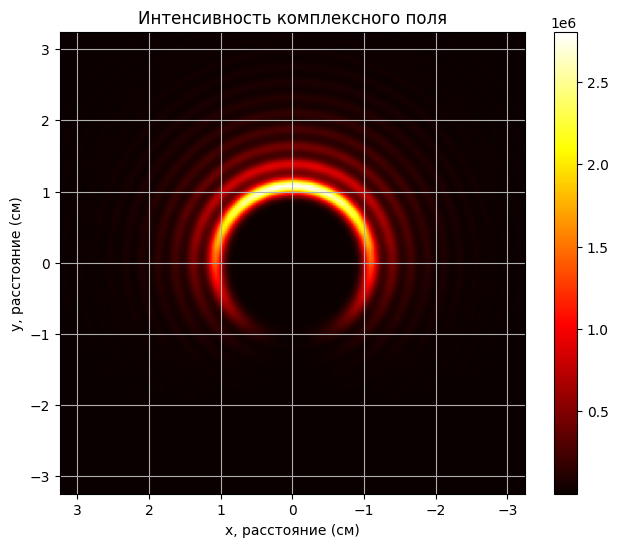

In [112]:
this_m = [-29, -28]
(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field2_after_tilt_and_fft(a=5, N=181, M=505, m=this_m, c=[0.5, 0.5], sigma=1, alpha=0.0)
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2, print_mode=["intensity"])
    